# Moments Parameter Analysis: Best Fit vs Ground Truth

This notebook analyzes the moments optimization results from demographic inference experiments, comparing best fit parameters against ground truth values and visualizing parameter distributions across replicates.

## Import Required Libraries

Import necessary libraries for data manipulation and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from pathlib import Path
import glob
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration and Path Setup

Define paths to the experiment directories containing simulations and results.

In [9]:
# Define base paths - MODIFY THESE FOR YOUR EXPERIMENT
EXPERIMENT_NAME = 'drosophila_three_epoch'  # Change this to your experiment name
base_path = Path(f'/home/akapoor/kernlab/Infer_Demography/experiments/{EXPERIMENT_NAME}')
simulations_path = base_path / 'simulations'
runs_path = base_path / 'runs'

# Analysis configuration
MAX_SIMS_TO_PLOT = 50  # Set to a number (e.g., 10) to limit simulations plotted, or None for all
RANDOM_SUBSET = False    # If True and MAX_SIMS_TO_PLOT is set, randomly sample simulations

# Output directory for results
output_dir = Path('/home/akapoor/kernlab/Infer_Demography/notebooks/analysis_results')
output_dir.mkdir(exist_ok=True)

print(f"Configuration:")
print(f"  Experiment: {EXPERIMENT_NAME}")
print(f"  Base path: {base_path}")
print(f"  Simulations path: {simulations_path}")
print(f"  Runs path: {runs_path}")
print(f"  Output directory: {output_dir}")
print(f"  Max simulations to plot: {MAX_SIMS_TO_PLOT if MAX_SIMS_TO_PLOT else 'All'}")
print(f"  Random subset: {RANDOM_SUBSET}")

# Verify paths exist
print(f"\nPath verification:")
print(f"  Base path exists: {base_path.exists()}")
print(f"  Simulations exists: {simulations_path.exists()}")
print(f"  Runs exists: {runs_path.exists()}")

if not all([base_path.exists(), simulations_path.exists(), runs_path.exists()]):
    print("\n⚠️  WARNING: Some paths don't exist. Please check the EXPERIMENT_NAME and paths.")
else:
    print("\n✅ All paths verified successfully!")

Configuration:
  Experiment: drosophila_three_epoch
  Base path: /home/akapoor/kernlab/Infer_Demography/experiments/drosophila_three_epoch
  Simulations path: /home/akapoor/kernlab/Infer_Demography/experiments/drosophila_three_epoch/simulations
  Runs path: /home/akapoor/kernlab/Infer_Demography/experiments/drosophila_three_epoch/runs
  Output directory: /home/akapoor/kernlab/Infer_Demography/notebooks/analysis_results
  Max simulations to plot: 50
  Random subset: False

Path verification:
  Base path exists: True
  Simulations exists: True
  Runs exists: True

✅ All paths verified successfully!


## Data Loading Functions

Define comprehensive functions to load ground truth parameters and moments results.

In [10]:
def load_ground_truth_parameters(simulations_path, max_sims=None, random_subset=False):
    """Load ground truth parameters from simulation directories."""
    ground_truth = {}
    
    print("Loading ground truth parameters...")
    
    # Get all simulation directories first
    all_sim_dirs = sorted([d for d in simulations_path.glob('*') if d.is_dir()])
    
    # Apply simulation limit if specified
    if max_sims and max_sims < len(all_sim_dirs):
        if random_subset:
            import random
            selected_dirs = random.sample(all_sim_dirs, max_sims)
        else:
            selected_dirs = all_sim_dirs[:max_sims]
        print(f"  Selected {len(selected_dirs)} of {len(all_sim_dirs)} simulations ({'random' if random_subset else 'first N'})")
        sim_dirs_to_process = selected_dirs
    else:
        sim_dirs_to_process = all_sim_dirs
    
    # Iterate through selected simulation directories
    for sim_dir in sorted(sim_dirs_to_process):
        sim_id = sim_dir.name
        param_file = sim_dir / 'sampled_params.pkl'
        
        if param_file.exists():
            try:
                with open(param_file, 'rb') as f:
                    params = pickle.load(f)
                ground_truth[sim_id] = params
            except Exception as e:
                print(f"  Error loading {param_file}: {e}")
        else:
            print(f"  Parameter file not found: {param_file}")
    
    print(f"  Loaded ground truth for {len(ground_truth)} simulations")
    return ground_truth

def load_moments_results(runs_path, max_sims=None, random_subset=False):
    """Load moments best fit results from run directories."""
    moments_results = {}
    
    print("Loading moments results...")
    
    # Search for moments result files in run directories
    all_run_dirs = sorted(runs_path.glob('run_*_*'))
    print(f"  Found {len(all_run_dirs)} run directories")
    
    # Parse run directories to get simulation IDs
    sim_run_mapping = {}
    for run_dir in all_run_dirs:
        if run_dir.is_dir():
            run_name = run_dir.name
            # Parse run name (format: run_sim_rep, e.g., run_0_1)
            parts = run_name.split('_')
            if len(parts) >= 3:
                sim_id = parts[1]
                rep_id = parts[2]
                
                if sim_id not in sim_run_mapping:
                    sim_run_mapping[sim_id] = []
                sim_run_mapping[sim_id].append((run_dir, rep_id))
    
    # Apply simulation limit if specified
    all_sim_ids = sorted(sim_run_mapping.keys())
    if max_sims and max_sims < len(all_sim_ids):
        if random_subset:
            import random
            selected_sims = random.sample(all_sim_ids, max_sims)
        else:
            selected_sims = all_sim_ids[:max_sims]
        print(f"  Selected {len(selected_sims)} of {len(all_sim_ids)} simulations ({'random' if random_subset else 'first N'})")
        sims_to_process = selected_sims
    else:
        sims_to_process = all_sim_ids
    
    # Process selected simulations
    for sim_id in sims_to_process:
        if sim_id in sim_run_mapping:
            for run_dir, rep_id in sim_run_mapping[sim_id]:
                moments_dir = run_dir / 'inferences' / 'moments'
                
                if not moments_dir.exists():
                    continue
                    
                # Look for moments output files
                possible_files = [
                    moments_dir / 'best_fit.pkl',
                    moments_dir / 'fit_params.pkl',
                    moments_dir / 'optimization_results.pkl',
                    moments_dir / 'moments_results.pkl',
                    moments_dir / 'results.pkl'
                ]
                
                result_data = {}
                
                # Load all available result files
                for result_file in possible_files:
                    if result_file.exists():
                        try:
                            with open(result_file, 'rb') as f:
                                data = pickle.load(f)
                            result_data[result_file.name] = data
                        except Exception as e:
                            print(f"  Error loading {result_file}: {e}")
                
                if result_data:
                    if sim_id not in moments_results:
                        moments_results[sim_id] = {}
                    
                    moments_results[sim_id][rep_id] = {
                        'results': result_data,
                        'directory': moments_dir
                    }
    
    print(f"  Loaded moments results for {len(moments_results)} simulations")
    return moments_results

def extract_moments_parameters(results_data):
    """Extract parameter values from moments results data structure."""
    params = {}
    likelihood = None
    
    # Try to extract from different file types
    for file_name, data in results_data.items():
        
        if file_name == 'best_fit.pkl':
            if isinstance(data, dict):
                # Look for parameter keys
                param_keys = ['best_params', 'optimal_params', 'parameters', 'params']
                for key in param_keys:
                    if key in data:
                        if isinstance(data[key], dict):
                            params.update(data[key])
                        elif isinstance(data[key], (list, tuple, np.ndarray)):
                            # Map to parameter names (adjust for your model)
                            param_names = ['N1', 'N2', 'm12', 'm21', 't_split', 'N0']
                            if len(data[key]) <= len(param_names):
                                params.update(dict(zip(param_names[:len(data[key])], data[key])))
                        break
                
                # Look for likelihood
                ll_keys = ['best_lls', 'likelihood', 'll', 'log_likelihood', 'best_ll']
                for key in ll_keys:
                    if key in data:
                        likelihood = data[key]
                        break
            
            elif isinstance(data, (list, tuple, np.ndarray)):
                # If best_fit.pkl contains just parameter values
                param_names = ['N1', 'N2', 'm12', 'm21', 't_split', 'N0']
                if len(data) <= len(param_names):
                    params = dict(zip(param_names[:len(data)], data))
        
        elif file_name == 'fit_params.pkl':
            if isinstance(data, dict):
                params.update(data)
            elif isinstance(data, (list, tuple, np.ndarray)):
                param_names = ['N1', 'N2', 'm12', 'm21', 't_split', 'N0']
                if len(data) <= len(param_names):
                    params.update(dict(zip(param_names[:len(data)], data)))
    
    # Add likelihood to params if found
    if likelihood is not None:
        params['log_likelihood'] = likelihood
    
    return params

print("Data loading functions defined successfully!")

Data loading functions defined successfully!


## Load Data

Load ground truth parameters and moments optimization results.

In [11]:
# Load ground truth parameters with simulation limit
print(f"Loading data with simulation limit: {MAX_SIMS_TO_PLOT if MAX_SIMS_TO_PLOT else 'All simulations'}")
ground_truth_params = load_ground_truth_parameters(simulations_path, max_sims=MAX_SIMS_TO_PLOT, random_subset=RANDOM_SUBSET)

# Load moments results with simulation limit  
moments_results = load_moments_results(runs_path, max_sims=MAX_SIMS_TO_PLOT, random_subset=RANDOM_SUBSET)

# Display summary
print(f"\nData Loading Summary:")
print(f"  Ground truth simulations: {len(ground_truth_params)}")
print(f"  Moments results simulations: {len(moments_results)}")

if MAX_SIMS_TO_PLOT:
    print(f"  Limited to: {MAX_SIMS_TO_PLOT} simulations ({'random' if RANDOM_SUBSET else 'first N'})")

if ground_truth_params:
    first_sim = list(ground_truth_params.keys())[0]
    print(f"\nExample parameters for simulation {first_sim}:")
    for key, value in ground_truth_params[first_sim].items():
        print(f"  {key}: {value:.6f}" if isinstance(value, float) else f"  {key}: {value}")

if moments_results:
    print(f"\nMoments results per simulation:")
    for sim_id, sim_results in sorted(moments_results.items()):
        print(f"  Simulation {sim_id}: {len(sim_results)} replicates")

# Check data availability
if not ground_truth_params:
    print("\n⚠️  WARNING: No ground truth parameters loaded!")
if not moments_results:
    print("\n⚠️  WARNING: No moments results loaded!")
    
if ground_truth_params and moments_results:
    print("\n✅ Data loaded successfully!")

Loading data with simulation limit: 50
Loading ground truth parameters...
  Selected 50 of 1000 simulations (first N)
  Loaded ground truth for 50 simulations
Loading moments results...
  Found 100000 run directories
  Selected 50 of 1000 simulations (first N)
  Loaded moments results for 50 simulations

Data Loading Summary:
  Ground truth simulations: 50
  Moments results simulations: 50
  Limited to: 50 simulations (first N)

Example parameters for simulation 0:
  N0: 19974.066634
  AFR: 28331.496668
  EUR_bottleneck: 3124.373677
  EUR_recover: 3128.442516
  T_AFR_expansion: 168368.478742
  T_AFR_EUR_split: 12972.437323
  T_EUR_expansion: 6168.360088

Moments results per simulation:
  Simulation 0: 100 replicates
  Simulation 1: 100 replicates
  Simulation 10: 100 replicates
  Simulation 100: 100 replicates
  Simulation 101: 100 replicates
  Simulation 102: 100 replicates
  Simulation 103: 100 replicates
  Simulation 104: 100 replicates
  Simulation 105: 100 replicates
  Simulation 

## Create Comparison DataFrame

Process the loaded data into a comprehensive comparison dataframe.

In [12]:
def create_moments_comparison_dataframe(ground_truth_params, moments_results):
    """Create a DataFrame comparing ground truth vs estimated parameters for moments."""
    comparison_data = []
    
    print("Creating comparison dataframe...")
    
    for sim_id in ground_truth_params.keys():
        if sim_id in moments_results:
            gt_params = ground_truth_params[sim_id]
            
            for rep_id, rep_data in moments_results[sim_id].items():
                est_params = extract_moments_parameters(rep_data['results'])
                
                # Create a row for each parameter
                for param_name in gt_params.keys():
                    if param_name in est_params:
                        gt_val = gt_params[param_name]
                        est_val = est_params[param_name]
                        
                        comparison_data.append({
                            'simulation': sim_id,
                            'replicate': rep_id,
                            'parameter': param_name,
                            'ground_truth': gt_val,
                            'estimated': est_val,
                            'absolute_error': est_val - gt_val,
                            'relative_error': (est_val - gt_val) / gt_val if gt_val != 0 else np.nan
                        })
                
                # Add likelihood if available
                if 'log_likelihood' in est_params:
                    comparison_data.append({
                        'simulation': sim_id,
                        'replicate': rep_id,
                        'parameter': 'log_likelihood',
                        'ground_truth': np.nan,
                        'estimated': est_params['log_likelihood'],
                        'absolute_error': np.nan,
                        'relative_error': np.nan
                    })
    
    df = pd.DataFrame(comparison_data)
    print(f"  Created dataframe with {len(df)} rows")
    return df

# Create comparison dataframe
if ground_truth_params and moments_results:
    df_moments_comparison = create_moments_comparison_dataframe(ground_truth_params, moments_results)
    
    if not df_moments_comparison.empty:
        print(f"\nDataFrame Summary:")
        print(f"  Total rows: {len(df_moments_comparison)}")
        print(f"  Parameters: {sorted(df_moments_comparison['parameter'].unique())}")
        print(f"  Simulations: {sorted(df_moments_comparison['simulation'].unique())}")
        print(f"  Replicates per simulation: {df_moments_comparison.groupby('simulation')['replicate'].nunique().to_dict()}")
        
        # Show sample data
        print(f"\nSample comparison data:")
        sample_data = df_moments_comparison[df_moments_comparison['parameter'] != 'log_likelihood'].head(10)
        if not sample_data.empty:
            display_cols = ['simulation', 'replicate', 'parameter', 'ground_truth', 'estimated', 'relative_error']
            print(sample_data[display_cols].round(4))
    else:
        print("\n⚠️  DataFrame is empty - no matching parameters found")
else:
    print("\n⚠️  Cannot create comparison DataFrame - missing data")
    df_moments_comparison = pd.DataFrame()

Creating comparison dataframe...
  Created dataframe with 40000 rows

DataFrame Summary:
  Total rows: 40000
  Parameters: ['AFR', 'EUR_bottleneck', 'EUR_recover', 'N0', 'T_AFR_EUR_split', 'T_AFR_expansion', 'T_EUR_expansion', 'log_likelihood']
  Simulations: ['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142']
  Replicates per simulation: {'0': 100, '1': 100, '10': 100, '100': 100, '101': 100, '102': 100, '103': 100, '104': 100, '105': 100, '106': 100, '107': 100, '108': 100, '109': 100, '11': 100, '110': 100, '111': 100, '112': 100, '113': 100, '114': 100, '115': 100, '116': 100, '117': 100, '118': 100, '119': 100, '12': 100, '120': 100, '121': 100, '122': 100, '123': 100, '124': 100, '125': 100, '12

## Analysis Functions

Define functions for parameter analysis and visualization.

In [13]:
def plot_parameter_comparison(df, parameter_name, title_prefix="Moments", max_sims=None, random_subset=False):
    """Plot ground truth vs estimated values for a specific parameter."""
    param_data = df[(df['parameter'] == parameter_name) & (df['parameter'] != 'log_likelihood')]
    
    if len(param_data) == 0:
        print(f"No data found for parameter {parameter_name}")
        return None
    
    # Filter simulations if requested
    unique_sims = sorted(param_data['simulation'].unique())
    if max_sims and max_sims < len(unique_sims):
        if random_subset:
            import random
            selected_sims = random.sample(unique_sims, max_sims)
        else:
            selected_sims = unique_sims[:max_sims]
        param_data = param_data[param_data['simulation'].isin(selected_sims)]
        unique_sims = sorted(selected_sims)
        print(f"  Plotting {len(unique_sims)} of {len(sorted(df[df['parameter'] == parameter_name]['simulation'].unique()))} simulations for {parameter_name}")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot: Ground truth vs Estimated
    ax1 = axes[0]
    
    # Color by simulation
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_sims)))
    
    for i, sim_id in enumerate(unique_sims):
        sim_data = param_data[param_data['simulation'] == sim_id]
        ax1.scatter(sim_data['ground_truth'], sim_data['estimated'], 
                   label=f'Sim {sim_id}', alpha=0.7, s=50, color=colors[i])
    
    # Add identity line
    min_val = min(param_data['ground_truth'].min(), param_data['estimated'].min())
    max_val = max(param_data['ground_truth'].max(), param_data['estimated'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect fit')
    
    ax1.set_xlabel(f'Ground Truth {parameter_name}')
    ax1.set_ylabel(f'Estimated {parameter_name}')
    ax1.set_title(f'{title_prefix} - {parameter_name}: Ground Truth vs Estimated')
    ax1.grid(True, alpha=0.3)
    
    # Show legend only if reasonable number of simulations
    if len(unique_sims) <= 10:
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Relative error histogram
    ax2 = axes[1]
    valid_errors = param_data['relative_error'].dropna()
    
    if len(valid_errors) > 0:
        ax2.hist(valid_errors, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
        ax2.axvline(0, color='red', linestyle='--', label='Perfect estimate')
        ax2.axvline(valid_errors.median(), color='blue', linestyle='-', 
                   label=f'Median: {valid_errors.median():.3f}')
        ax2.axvline(valid_errors.mean(), color='green', linestyle=':', 
                   label=f'Mean: {valid_errors.mean():.3f}')
    
    ax2.set_xlabel('Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{title_prefix} - {parameter_name}: Relative Error Distribution')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    valid_data = param_data.dropna(subset=['ground_truth', 'estimated', 'relative_error'])
    if len(valid_data) > 0:
        correlation = valid_data['ground_truth'].corr(valid_data['estimated'])
        print(f"\n{title_prefix} Summary for {parameter_name}:")
        print(f"  Number of estimates: {len(valid_data)}")
        print(f"  Correlation coefficient: {correlation:.4f}")
        print(f"  Mean relative error: {valid_data['relative_error'].mean():.4f}")
        print(f"  Median relative error: {valid_data['relative_error'].median():.4f}")
        print(f"  Std relative error: {valid_data['relative_error'].std():.4f}")
        print(f"  RMSE: {np.sqrt((valid_data['absolute_error']**2).mean()):.4f}")
    
    return fig

def calculate_parameter_statistics(df, title_prefix="Moments"):
    """Calculate comprehensive statistics for parameter estimates."""
    stats_results = []
    
    # Exclude log_likelihood from analysis
    param_df = df[df['parameter'] != 'log_likelihood']
    
    for param in param_df['parameter'].unique():
        param_data = param_df[param_df['parameter'] == param]
        
        for sim_id in param_data['simulation'].unique():
            sim_data = param_data[param_data['simulation'] == sim_id]
            valid_data = sim_data.dropna(subset=['ground_truth', 'estimated'])
            
            if len(valid_data) == 0:
                continue
                
            gt_value = valid_data['ground_truth'].iloc[0]
            estimates = valid_data['estimated']
            
            stats_results.append({
                'parameter': param,
                'simulation': sim_id,
                'ground_truth': gt_value,
                'mean_estimate': estimates.mean(),
                'median_estimate': estimates.median(),
                'std_estimate': estimates.std(),
                'bias': estimates.mean() - gt_value,
                'relative_bias': (estimates.mean() - gt_value) / gt_value if gt_value != 0 else np.nan,
                'rmse': np.sqrt(((estimates - gt_value) ** 2).mean()),
                'relative_rmse': np.sqrt(((estimates - gt_value) ** 2).mean()) / abs(gt_value) if gt_value != 0 else np.nan,
                'n_replicates': len(estimates)
            })
    
    return pd.DataFrame(stats_results)

print("Analysis functions defined successfully!")

Analysis functions defined successfully!


## Parameter-wise Analysis

Analyze each parameter individually with scatter plots and error distributions.

Analyzing 7 parameters: ['N0', 'AFR', 'EUR_bottleneck', 'EUR_recover', 'T_AFR_expansion', 'T_AFR_EUR_split', 'T_EUR_expansion']
Limiting plots to 50 of 50 simulations


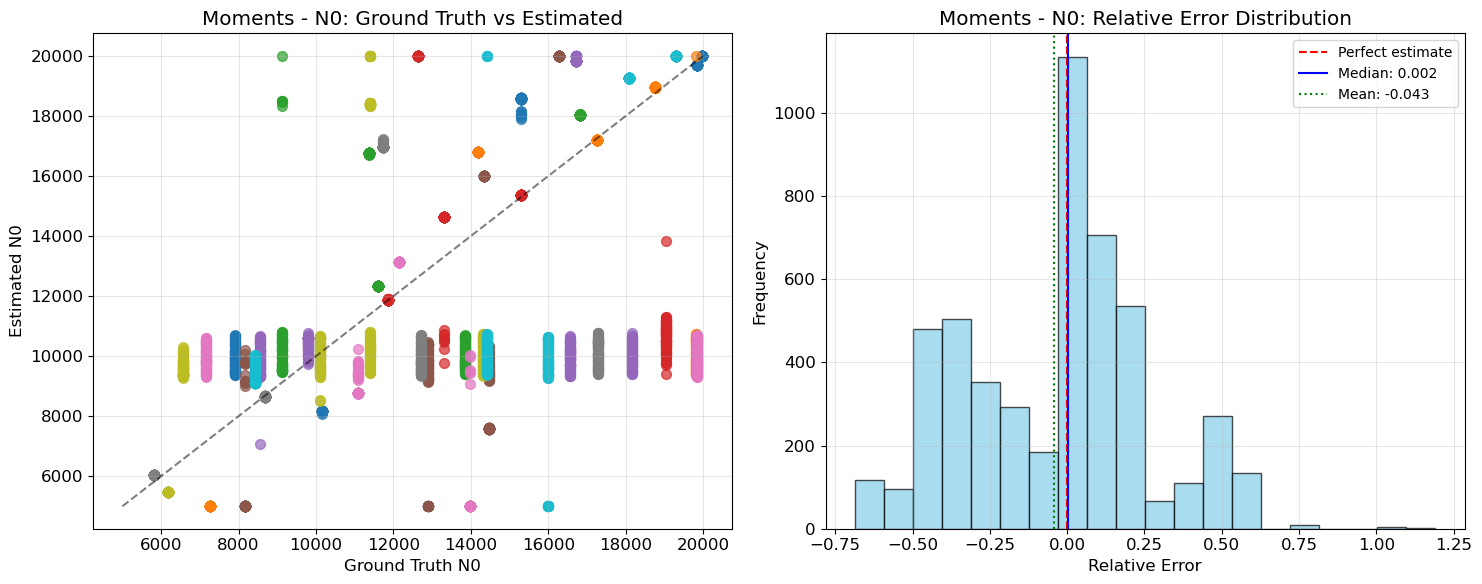


Moments Summary for N0:
  Number of estimates: 5000
  Correlation coefficient: 0.5529
  Mean relative error: -0.0429
  Median relative error: 0.0021
  Std relative error: 0.2950
  RMSE: 4256.7260

--------------------------------------------------------------------------------



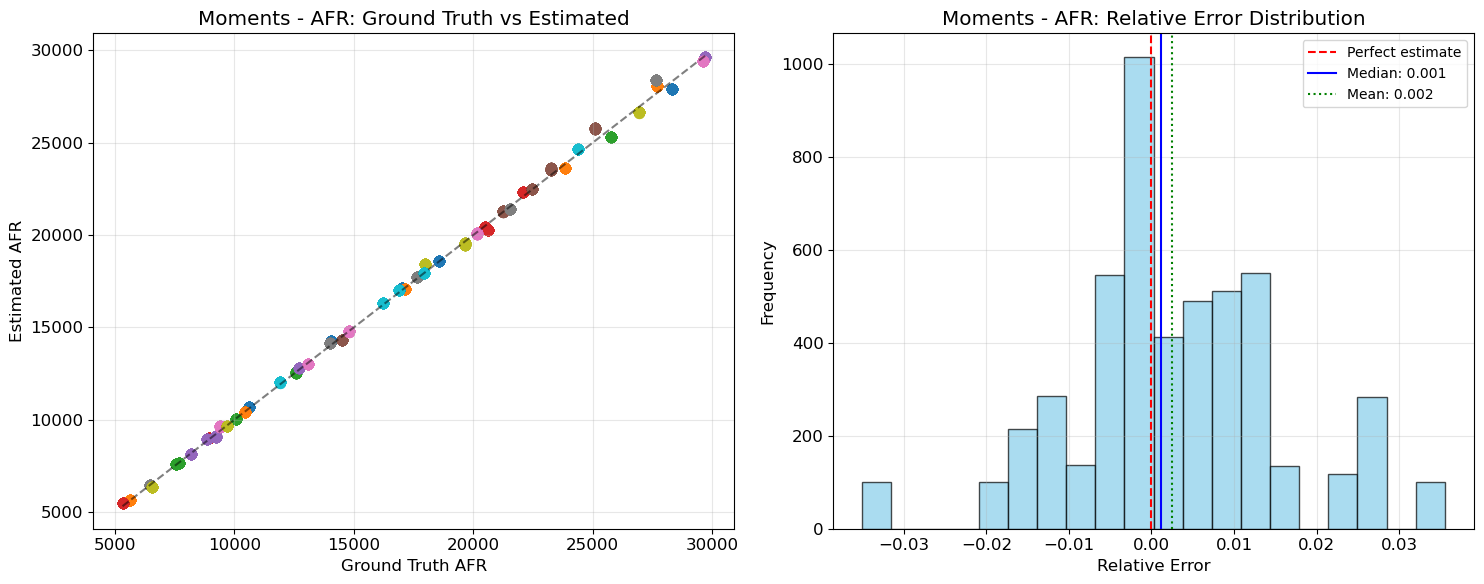


Moments Summary for AFR:
  Number of estimates: 5000
  Correlation coefficient: 0.9995
  Mean relative error: 0.0024
  Median relative error: 0.0012
  Std relative error: 0.0126
  RMSE: 230.8088

--------------------------------------------------------------------------------



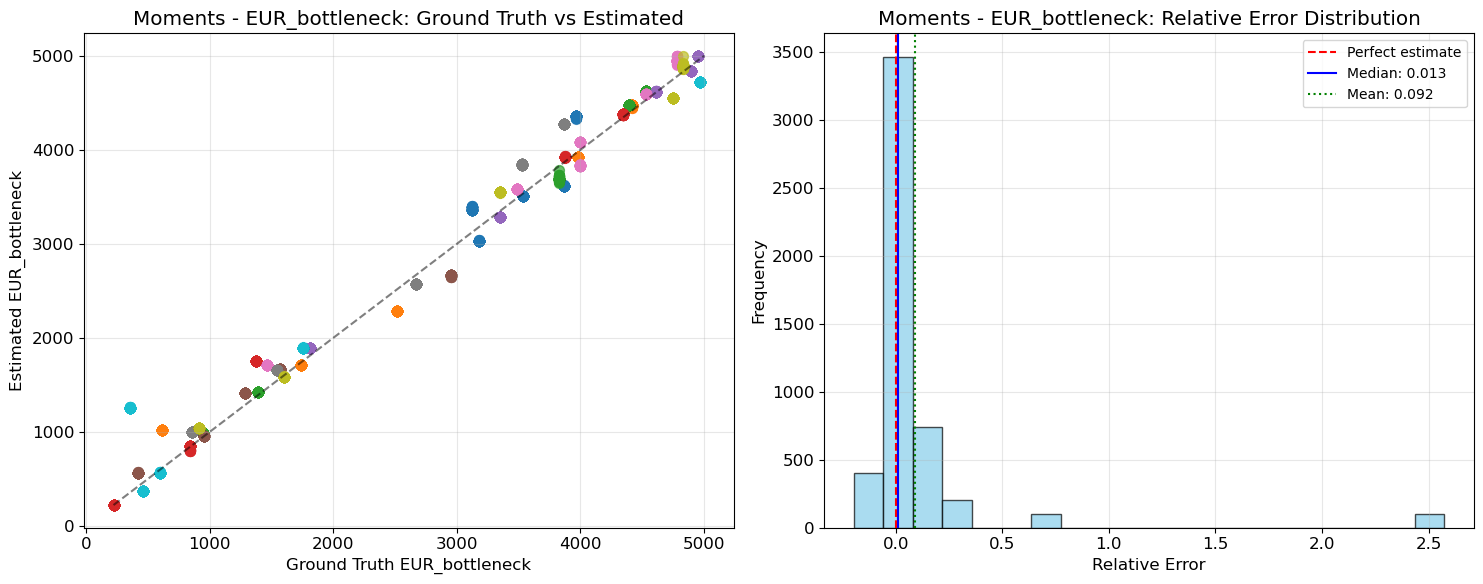


Moments Summary for EUR_bottleneck:
  Number of estimates: 5000
  Correlation coefficient: 0.9915
  Mean relative error: 0.0918
  Median relative error: 0.0127
  Std relative error: 0.3746
  RMSE: 215.0627

--------------------------------------------------------------------------------



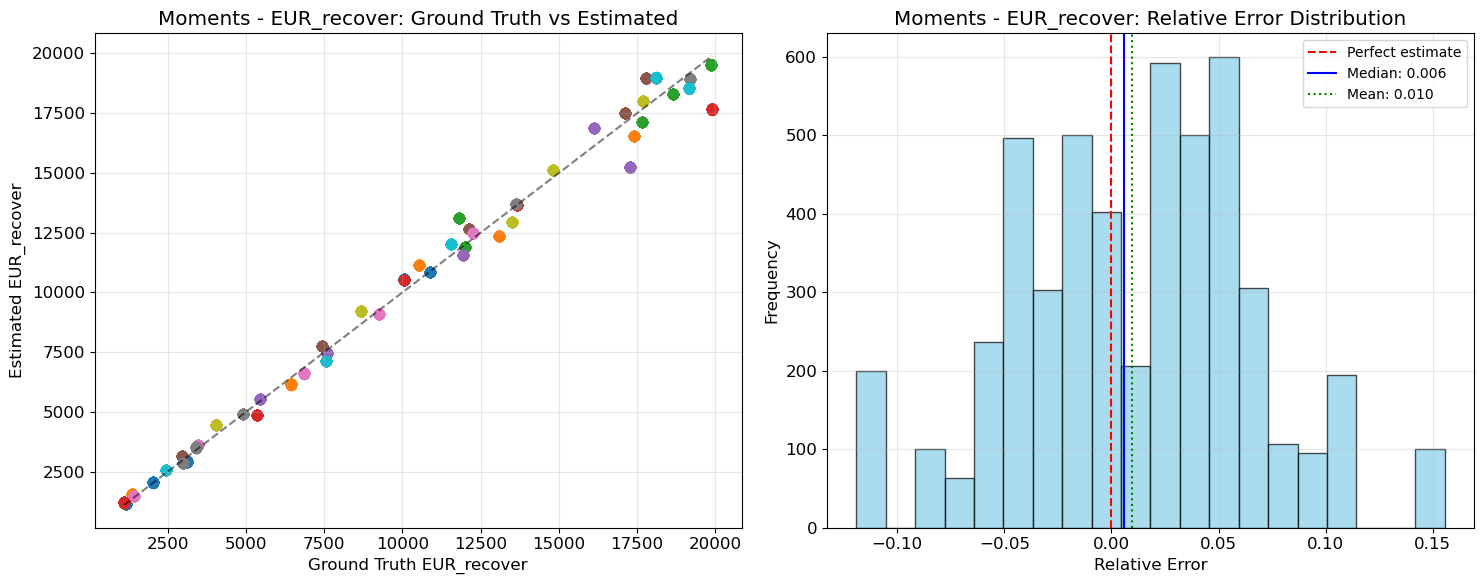


Moments Summary for EUR_recover:
  Number of estimates: 5000
  Correlation coefficient: 0.9945
  Mean relative error: 0.0095
  Median relative error: 0.0058
  Std relative error: 0.0557
  RMSE: 625.4531

--------------------------------------------------------------------------------



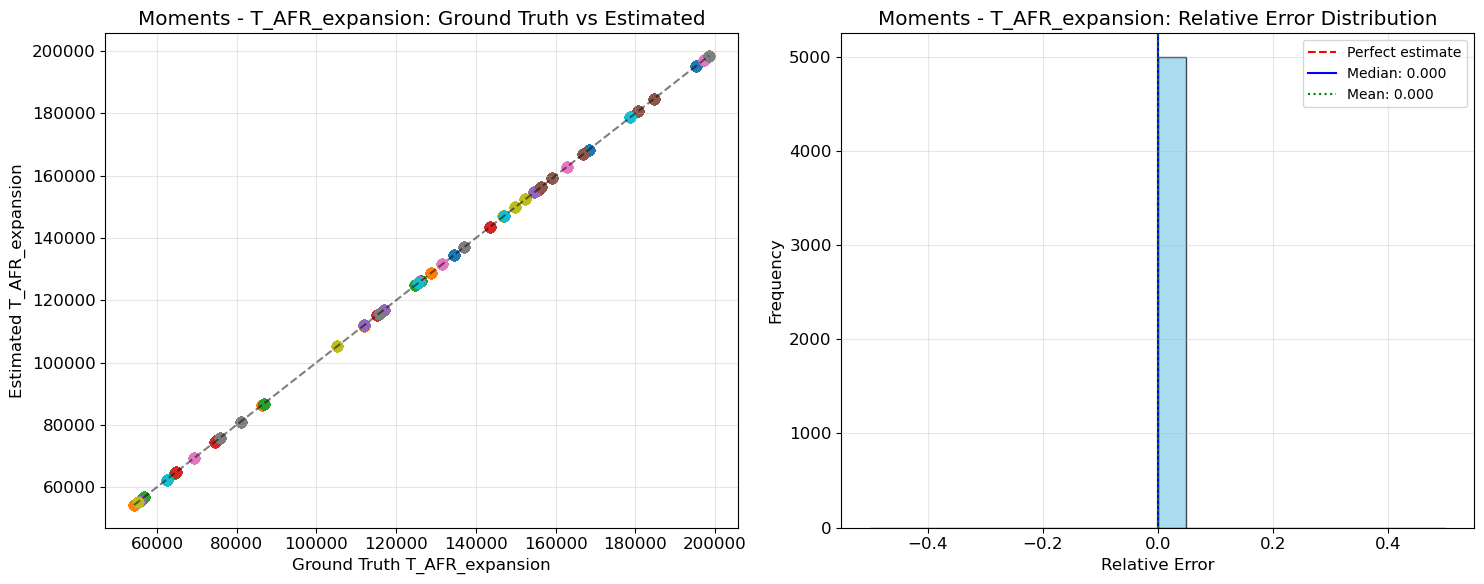


Moments Summary for T_AFR_expansion:
  Number of estimates: 5000
  Correlation coefficient: 1.0000
  Mean relative error: 0.0000
  Median relative error: 0.0000
  Std relative error: 0.0000
  RMSE: 0.0000

--------------------------------------------------------------------------------



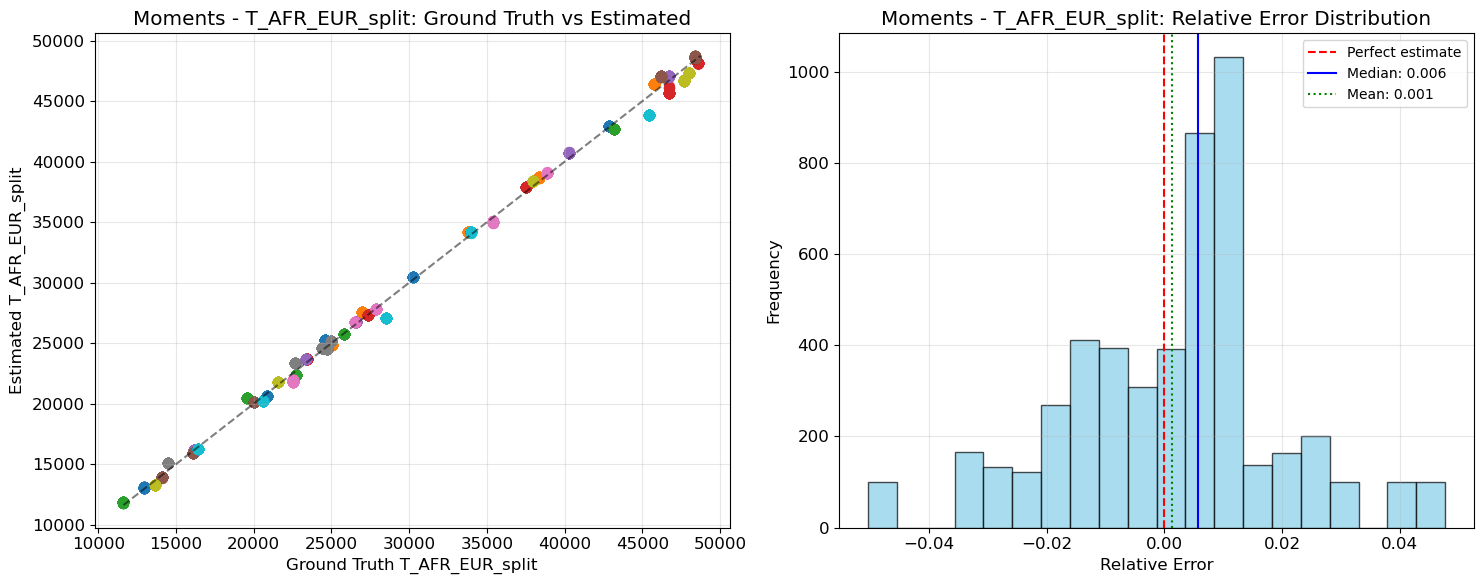


Moments Summary for T_AFR_EUR_split:
  Number of estimates: 5000
  Correlation coefficient: 0.9989
  Mean relative error: 0.0013
  Median relative error: 0.0057
  Std relative error: 0.0183
  RMSE: 529.8044

--------------------------------------------------------------------------------



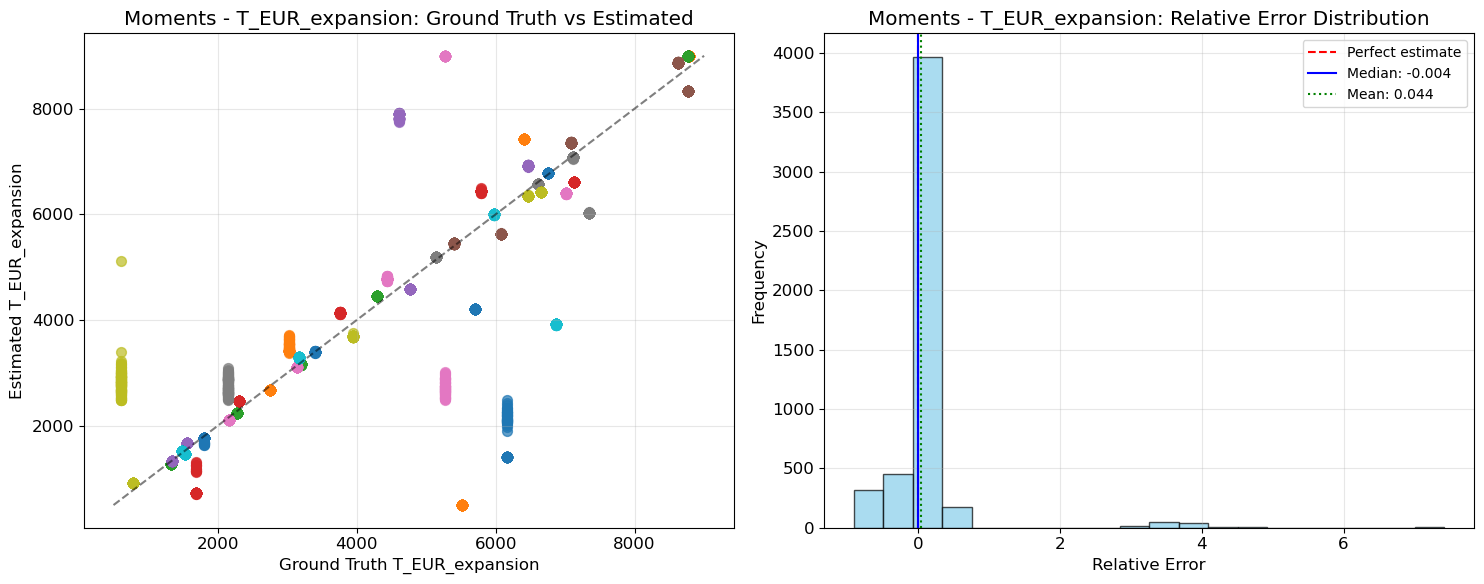


Moments Summary for T_EUR_expansion:
  Number of estimates: 5000
  Correlation coefficient: 0.8489
  Mean relative error: 0.0443
  Median relative error: -0.0044
  Std relative error: 0.5787
  RMSE: 1328.6278

--------------------------------------------------------------------------------



In [14]:
if not df_moments_comparison.empty:
    # Get parameters to analyze (excluding log_likelihood)
    params_to_plot = [p for p in df_moments_comparison['parameter'].unique() if p != 'log_likelihood']
    
    print(f"Analyzing {len(params_to_plot)} parameters: {params_to_plot}")
    if MAX_SIMS_TO_PLOT:
        total_sims = len(df_moments_comparison['simulation'].unique())
        print(f"Limiting plots to {min(MAX_SIMS_TO_PLOT, total_sims)} of {total_sims} simulations")
    print("=" * 60)
    
    # Plot each parameter
    for param in params_to_plot:
        plot_parameter_comparison(df_moments_comparison, param, "Moments", 
                                MAX_SIMS_TO_PLOT, RANDOM_SUBSET)
        print("\n" + "-"*80 + "\n")
        
else:
    print("No data available for parameter analysis")

## Statistical Summary

Calculate and display comprehensive statistics for all parameters.

In [9]:
if not df_moments_comparison.empty:
    # Calculate statistics
    moments_stats_df = calculate_parameter_statistics(df_moments_comparison, "Moments")
    
    if not moments_stats_df.empty:
        print("Detailed Parameter Statistics:")
        print("=" * 60)
        
        # Display detailed stats table
        display_cols = ['parameter', 'simulation', 'ground_truth', 'mean_estimate', 
                       'relative_bias', 'relative_rmse', 'n_replicates']
        print(moments_stats_df[display_cols].round(4).to_string(index=False))
        
        # Overall summary by parameter
        print("\n\nOverall Summary by Parameter:")
        print("=" * 50)
        
        overall_summary = moments_stats_df.groupby('parameter').agg({
            'relative_bias': ['mean', 'std', 'median'],
            'relative_rmse': ['mean', 'std', 'median'],
            'n_replicates': 'sum'
        }).round(4)
        
        print(overall_summary.to_string())
    
    else:
        print("No valid statistics calculated")
        
else:
    print("No data available for statistical analysis")

Detailed Parameter Statistics:
      parameter simulation  ground_truth  mean_estimate  relative_bias  relative_rmse  n_replicates
             N0          0    19974.0666     19974.0666        -0.0000         0.0000           100
             N0          1     7914.2613      7914.2613         0.0000         0.0000           100
             N0         10    15302.2277     15302.2277         0.0000         0.0000           100
             N0        100    19835.4410     19835.4410        -0.0000         0.0000           100
             N0        101    10146.7630     10146.7630         0.0000         0.0000           100
             N0        102     7264.2765      7264.2765         0.0000         0.0000           100
             N0        103    14177.8707     14177.8707         0.0000         0.0000           100
             N0        104    19804.2745     19804.2745         0.0000         0.0000           100
             N0        105    18764.0536     18764.0536         0.000

## Best Likelihood Analysis

For each simulation, identify the replicate with the highest likelihood and analyze those best estimates.

Best Likelihood Analysis
Found best estimates for 10 simulations
Parameters: ['AFR', 'EUR_bottleneck', 'EUR_recover', 'N0', 'T_AFR_EUR_split', 'T_AFR_expansion', 'T_EUR_expansion']

Best Estimates Statistical Summary:
--------------------------------------------------

AFR:
  Count: 10
  Mean relative error: 0.0000
  Median relative error: 0.0000
  Std relative error: 0.0000
  Within 5% accuracy: 10/10 (100.0%)
  Within 10% accuracy: 10/10 (100.0%)

EUR_bottleneck:
  Count: 10
  Mean relative error: 0.0551
  Median relative error: -0.0023
  Std relative error: 0.2267
  Within 5% accuracy: 4/10 (40.0%)
  Within 10% accuracy: 8/10 (80.0%)

EUR_recover:
  Count: 10
  Mean relative error: 0.0051
  Median relative error: 0.0015
  Std relative error: 0.0678
  Within 5% accuracy: 6/10 (60.0%)
  Within 10% accuracy: 9/10 (90.0%)

N0:
  Count: 10
  Mean relative error: 0.0000
  Median relative error: 0.0000
  Std relative error: 0.0000
  Within 5% accuracy: 10/10 (100.0%)
  Within 10% accuracy:

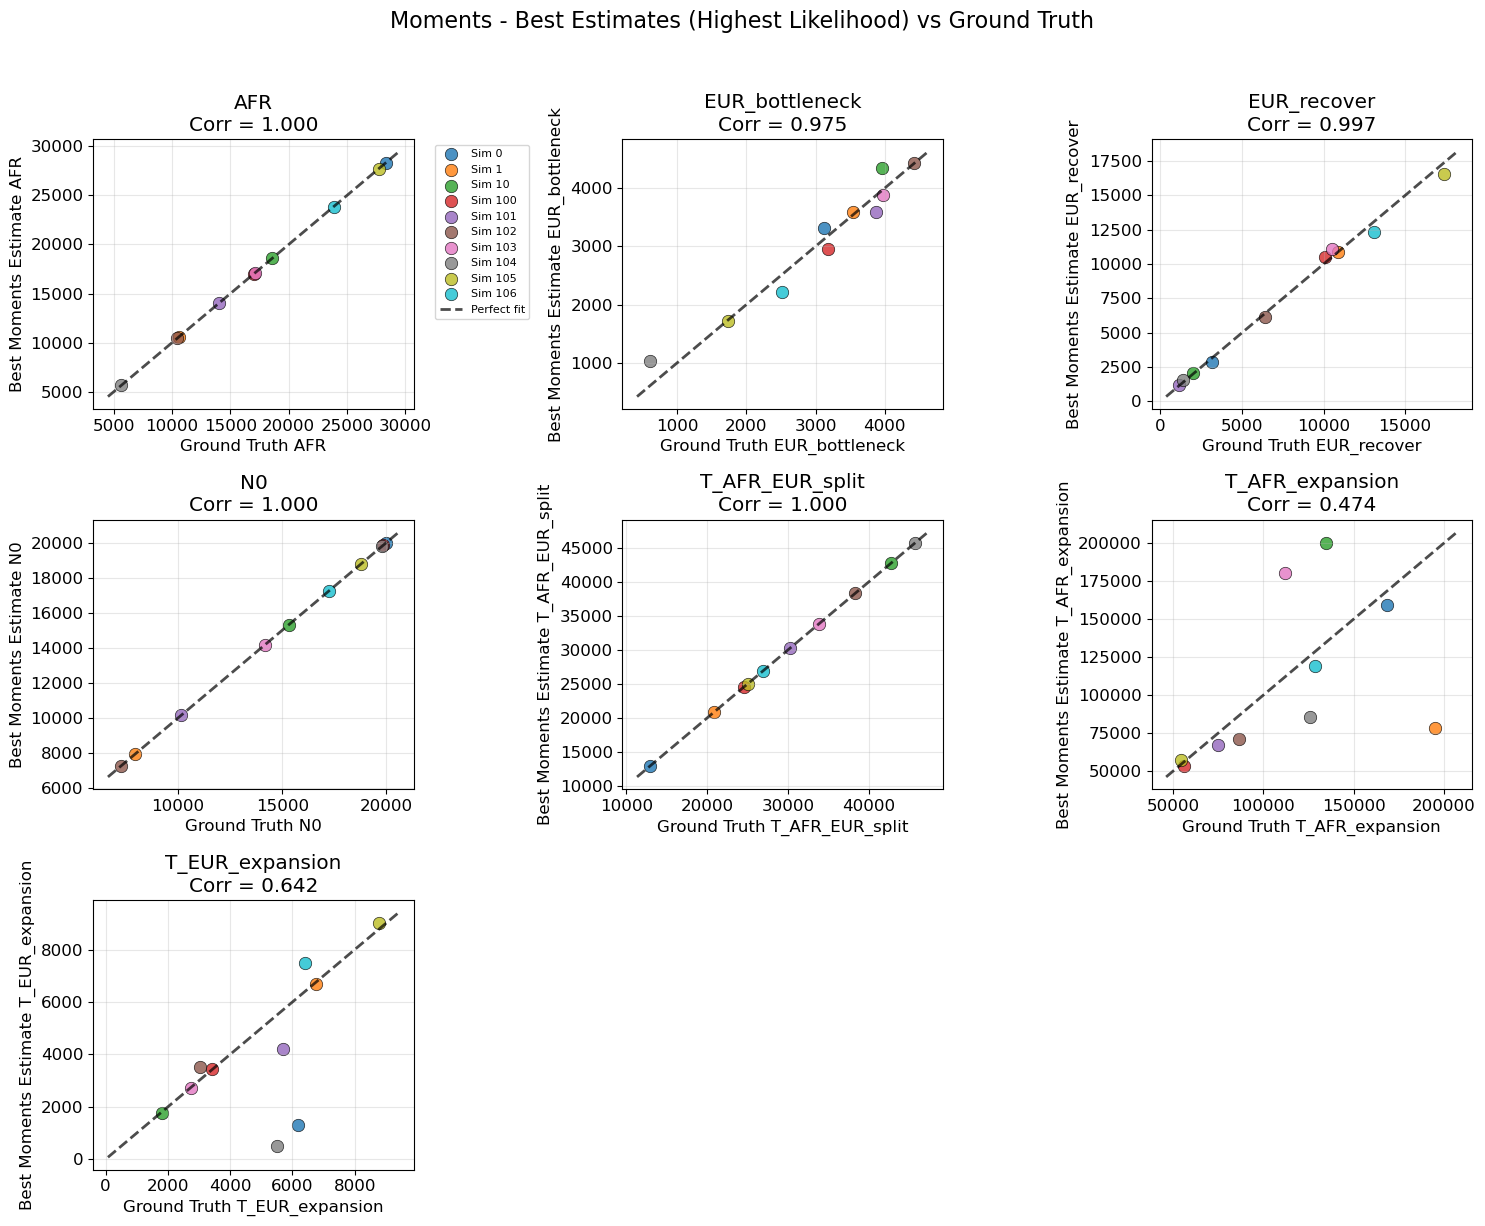

In [10]:
def get_best_estimates_per_simulation(df):
    """Get the best parameter estimates (highest likelihood) for each simulation."""
    
    # Filter to only likelihood data
    ll_data = df[df['parameter'] == 'log_likelihood'].copy()
    
    if ll_data.empty:
        print("No likelihood data found - cannot identify best estimates")
        return None
    
    # For each simulation, find the replicate with highest likelihood
    best_estimates = []
    
    for sim_id in ll_data['simulation'].unique():
        sim_ll_data = ll_data[ll_data['simulation'] == sim_id]
        
        # Find replicate with maximum likelihood
        best_rep_idx = sim_ll_data['estimated'].idxmax()
        best_rep_row = sim_ll_data.loc[best_rep_idx]
        best_replicate = best_rep_row['replicate']
        best_likelihood = best_rep_row['estimated']
        
        # Get all parameter estimates for this simulation and replicate
        sim_rep_data = df[(df['simulation'] == sim_id) & (df['replicate'] == best_replicate)]
        
        # Store the best estimates
        for _, row in sim_rep_data.iterrows():
            if row['parameter'] != 'log_likelihood':
                best_estimates.append({
                    'simulation': sim_id,
                    'replicate': best_replicate,
                    'parameter': row['parameter'],
                    'ground_truth': row['ground_truth'],
                    'best_estimate': row['estimated'],
                    'best_likelihood': best_likelihood,
                    'absolute_error': row['estimated'] - row['ground_truth'],
                    'relative_error': (row['estimated'] - row['ground_truth']) / row['ground_truth'] if row['ground_truth'] != 0 else np.nan
                })
    
    return pd.DataFrame(best_estimates)

def plot_best_estimates_vs_ground_truth(best_df, title_prefix="Moments", max_sims=None, random_subset=False):
    """Plot the best parameter estimates vs ground truth for all parameters."""
    
    if best_df is None or best_df.empty:
        print("No best estimates data available for plotting")
        return None
    
    # Filter simulations if requested
    unique_sims = sorted(best_df['simulation'].unique())
    if max_sims and max_sims < len(unique_sims):
        if random_subset:
            import random
            selected_sims = random.sample(unique_sims, max_sims)
        else:
            selected_sims = unique_sims[:max_sims]
        best_df = best_df[best_df['simulation'].isin(selected_sims)]
        unique_sims = sorted(selected_sims)
        print(f"  Plotting best estimates for {len(unique_sims)} of {len(sorted(best_df['simulation'].unique())) + len(unique_sims) - len(selected_sims)} simulations")
    
    parameters = sorted(best_df['parameter'].unique())
    n_params = len(parameters)
    
    if n_params == 0:
        print("No parameters found for plotting")
        return None
    
    # Create subplots
    cols = min(3, n_params)
    rows = (n_params + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_params == 1:
        axes = np.array([axes])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    # Color mapping for simulations
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_sims)))
    sim_color_map = {sim: colors[i] for i, sim in enumerate(unique_sims)}
    
    for i, param in enumerate(parameters):
        row = i // cols
        col = i % cols
        
        if n_params == 1:
            ax = axes[0]
        elif rows == 1:
            ax = axes[0, col] if cols > 1 else axes[col]
        else:
            ax = axes[row, col]
        
        param_data = best_df[best_df['parameter'] == param]
        
        # Scatter plot colored by simulation
        for sim_id in unique_sims:
            sim_data = param_data[param_data['simulation'] == sim_id]
            if not sim_data.empty:
                ax.scatter(sim_data['ground_truth'], sim_data['best_estimate'], 
                          color=sim_color_map[sim_id], alpha=0.8, s=80, 
                          label=f'Sim {sim_id}', edgecolors='black', linewidth=0.5)
        
        # Add identity line
        min_val = min(param_data['ground_truth'].min(), param_data['best_estimate'].min())
        max_val = max(param_data['ground_truth'].max(), param_data['best_estimate'].max())
        margin = 0.05 * (max_val - min_val)
        ax.plot([min_val-margin, max_val+margin], [min_val-margin, max_val+margin], 
                'k--', alpha=0.7, linewidth=2, label='Perfect fit')
        
        # Calculate and display correlation
        correlation = param_data['ground_truth'].corr(param_data['best_estimate'])
        
        ax.set_xlabel(f'Ground Truth {param}')
        ax.set_ylabel(f'Best {title_prefix} Estimate {param}')
        ax.set_title(f'{param}\nCorr = {correlation:.3f}')
        ax.grid(True, alpha=0.3)
        
        # Show legend only for first subplot if reasonable number of simulations
        if i == 0 and len(unique_sims) <= 12:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Hide empty subplots
    for i in range(n_params, rows * cols):
        row = i // cols
        col = i % cols
        if rows == 1:
            if cols > 1:
                axes[0, col].set_visible(False)
            else:
                axes[col].set_visible(False)
        else:
            axes[row, col].set_visible(False)
    
    plt.suptitle(f'{title_prefix} - Best Estimates (Highest Likelihood) vs Ground Truth', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return fig

# Perform best likelihood analysis
if not df_moments_comparison.empty:
    print("Best Likelihood Analysis")
    print("=" * 40)
    
    best_moments_df = get_best_estimates_per_simulation(df_moments_comparison)
    
    if best_moments_df is not None and not best_moments_df.empty:
        print(f"Found best estimates for {len(best_moments_df['simulation'].unique())} simulations")
        print(f"Parameters: {sorted(best_moments_df['parameter'].unique())}")
        
        # Display summary statistics
        print(f"\nBest Estimates Statistical Summary:")
        print("-" * 50)
        
        for param in sorted(best_moments_df['parameter'].unique()):
            param_data = best_moments_df[best_moments_df['parameter'] == param]
            
            print(f"\n{param}:")
            print(f"  Count: {len(param_data)}")
            print(f"  Mean relative error: {param_data['relative_error'].mean():.4f}")
            print(f"  Median relative error: {param_data['relative_error'].median():.4f}")
            print(f"  Std relative error: {param_data['relative_error'].std():.4f}")
            
            # Accuracy metrics
            within_5pct = (np.abs(param_data['relative_error']) <= 0.05).sum()
            within_10pct = (np.abs(param_data['relative_error']) <= 0.10).sum()
            total = len(param_data)
            print(f"  Within 5% accuracy: {within_5pct}/{total} ({100*within_5pct/total:.1f}%)")
            print(f"  Within 10% accuracy: {within_10pct}/{total} ({100*within_10pct/total:.1f}%)")
        
        # Create the visualization
        print(f"\nCreating best estimates visualization...")
        plot_best_estimates_vs_ground_truth(best_moments_df, "Moments", 
                                           MAX_SIMS_TO_PLOT, RANDOM_SUBSET)
        
    else:
        print("Could not create best estimates dataframe - check likelihood data")
        best_moments_df = None
        
else:
    print("No comparison data available for best likelihood analysis")
    best_moments_df = None

## Likelihood Distribution Analysis

Analyze the distribution of likelihood values across simulations and replicates.

Moments Likelihood Analysis:

Likelihood summary by simulation:
            N_reps      Mean_LL    Median_LL  Std_LL       Min_LL       Max_LL
simulation                                                                    
0              100  486874.1962  486874.1963  0.0000  486874.1961  486874.1963
1              100  282234.9415  282234.9415  0.0000  282234.9415  282234.9415
10             100  413498.0738  413498.0740  0.0018  413498.0594  413498.0740
100            100  395165.2039  395165.2039  0.0000  395165.2039  395165.2039
101            100  285723.8472  285723.8472  0.0000  285723.8470  285723.8472
102            100  288402.9146  288402.9146  0.0000  288402.9146  288402.9146
103            100  414416.9177  414416.9177  0.0000  414416.9174  414416.9177
104            100  189394.4508  189394.4508  0.0000  189394.4505  189394.4508
105            100  609089.1712  609089.1712  0.0000  609089.1712  609089.1712
106            100  536216.9252  536216.9252  0.0000  536216.9252  

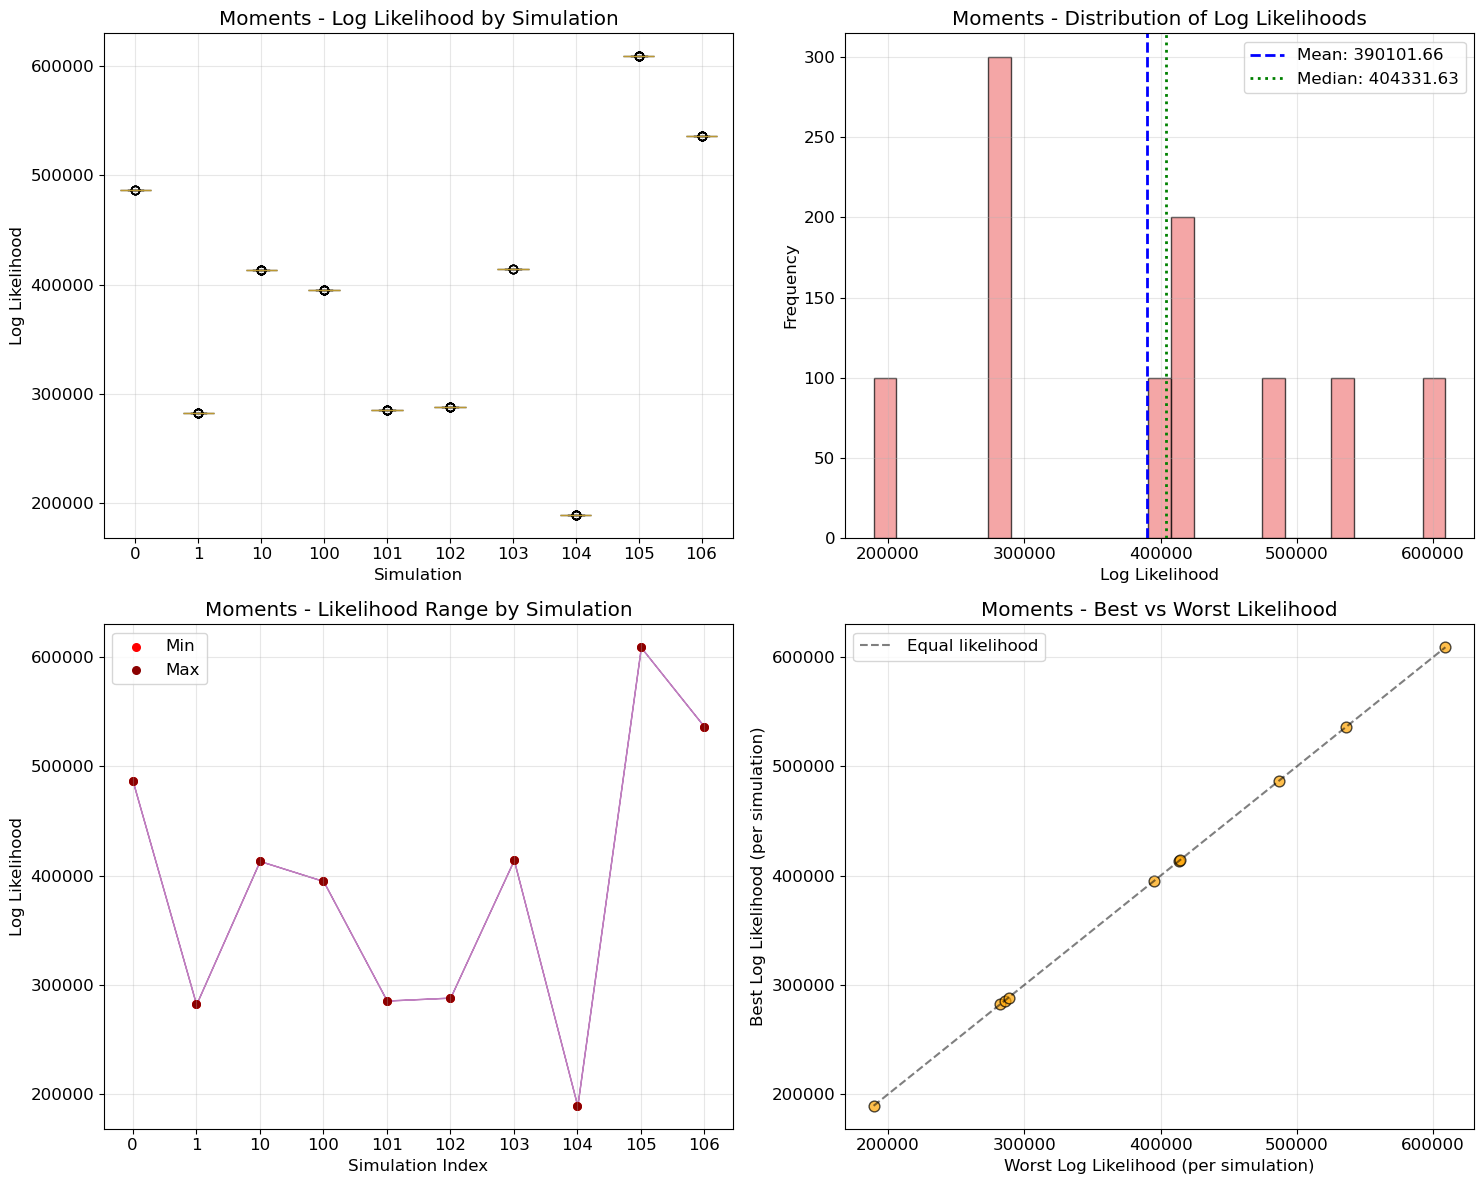


Overall likelihood statistics:
  Total estimates: 1000
  Mean: 390101.6642
  Median: 404331.6317
  Std: 123751.1644
  Range: [189394.4505, 609089.1712]


In [11]:
def analyze_likelihood_distribution(df, title_prefix="Moments", max_sims=None, random_subset=False):
    """Analyze likelihood values from optimization results."""
    ll_data = df[df['parameter'] == 'log_likelihood']
    
    if ll_data.empty:
        print(f"No likelihood data found in {title_prefix.lower()} results")
        return
    
    # Filter simulations if requested
    unique_sims = sorted(ll_data['simulation'].unique())
    if max_sims and max_sims < len(unique_sims):
        if random_subset:
            import random
            selected_sims = random.sample(unique_sims, max_sims)
        else:
            selected_sims = unique_sims[:max_sims]
        ll_data = ll_data[ll_data['simulation'].isin(selected_sims)]
        unique_sims = sorted(selected_sims)
        print(f"  Analyzing likelihood for {len(unique_sims)} of {len(sorted(df[df['parameter'] == 'log_likelihood']['simulation'].unique()))} simulations")
    
    print(f"{title_prefix} Likelihood Analysis:")
    print("=" * 40)
    
    # Summary statistics by simulation
    ll_summary = ll_data.groupby('simulation')['estimated'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(4)
    ll_summary.columns = ['N_reps', 'Mean_LL', 'Median_LL', 'Std_LL', 'Min_LL', 'Max_LL']
    
    print("\nLikelihood summary by simulation:")
    print(ll_summary.to_string())
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Box plot by simulation
    ax1 = axes[0, 0]
    simulations = sorted(ll_data['simulation'].unique())
    ll_by_sim = [ll_data[ll_data['simulation'] == sim]['estimated'].values for sim in simulations]
    
    bp = ax1.boxplot(ll_by_sim, labels=simulations, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    ax1.set_xlabel('Simulation')
    ax1.set_ylabel('Log Likelihood')
    ax1.set_title(f'{title_prefix} - Log Likelihood by Simulation')
    ax1.grid(True, alpha=0.3)
    
    # Overall histogram
    ax2 = axes[0, 1]
    ax2.hist(ll_data['estimated'], bins=25, alpha=0.7, edgecolor='black', color='lightcoral')
    ax2.axvline(ll_data['estimated'].mean(), color='blue', linestyle='--', linewidth=2,
               label=f'Mean: {ll_data["estimated"].mean():.2f}')
    ax2.axvline(ll_data['estimated'].median(), color='green', linestyle=':', linewidth=2,
               label=f'Median: {ll_data["estimated"].median():.2f}')
    ax2.set_xlabel('Log Likelihood')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{title_prefix} - Distribution of Log Likelihoods')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Likelihood range by simulation
    ax3 = axes[1, 0]
    sim_ranges = ll_data.groupby('simulation')['estimated'].agg(['min', 'max'])
    x_pos = range(len(sim_ranges))
    
    ax3.fill_between(x_pos, sim_ranges['min'], sim_ranges['max'], alpha=0.5, color='purple')
    ax3.scatter(x_pos, sim_ranges['min'], color='red', s=30, label='Min')
    ax3.scatter(x_pos, sim_ranges['max'], color='darkred', s=30, label='Max')
    
    ax3.set_xlabel('Simulation Index')
    ax3.set_ylabel('Log Likelihood')
    ax3.set_title(f'{title_prefix} - Likelihood Range by Simulation')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(sim_ranges.index)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Best vs worst likelihood comparison
    ax4 = axes[1, 1]
    best_ll = ll_data.groupby('simulation')['estimated'].max()
    worst_ll = ll_data.groupby('simulation')['estimated'].min()
    
    ax4.scatter(worst_ll, best_ll, alpha=0.7, s=60, color='orange', edgecolors='black')
    
    # Add identity line
    min_ll = min(worst_ll.min(), best_ll.min())
    max_ll = max(worst_ll.max(), best_ll.max())
    ax4.plot([min_ll, max_ll], [min_ll, max_ll], 'k--', alpha=0.5, label='Equal likelihood')
    
    ax4.set_xlabel('Worst Log Likelihood (per simulation)')
    ax4.set_ylabel('Best Log Likelihood (per simulation)')
    ax4.set_title(f'{title_prefix} - Best vs Worst Likelihood')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Overall statistics
    print(f"\nOverall likelihood statistics:")
    print(f"  Total estimates: {len(ll_data)}")
    print(f"  Mean: {ll_data['estimated'].mean():.4f}")
    print(f"  Median: {ll_data['estimated'].median():.4f}")
    print(f"  Std: {ll_data['estimated'].std():.4f}")
    print(f"  Range: [{ll_data['estimated'].min():.4f}, {ll_data['estimated'].max():.4f}]")
    
    return fig

# Perform likelihood analysis
if not df_moments_comparison.empty:
    analyze_likelihood_distribution(df_moments_comparison, "Moments", 
                                   MAX_SIMS_TO_PLOT, RANDOM_SUBSET)
else:
    print("No data available for likelihood analysis")

## Marginal Likelihood Surfaces

Generate 1D marginal likelihood surfaces for each parameter, similar to profile likelihood plots. This shows how the likelihood changes when varying one parameter while keeping others fixed at their optimal values.

In [12]:
# Demographic model functions (adjust these for your specific experiment)
def msprime_model_for_analysis(N_ANC, N_A, N_B, T, mAB, mBA):
    """
    Create msprime demography - adjust this function to match your experiment's model.
    This is a basic two-population split with migration model.
    """
    demogr = msprime.Demography()
    demogr.add_population(name="A", initial_size=N_A)
    demogr.add_population(name="B", initial_size=N_B)
    demogr.add_population(name="ANC", initial_size=N_ANC)
    demogr.add_population_split(time=T, ancestral="ANC", derived=["A", "B"])
    demogr.migration_matrix = np.array([[0, mAB, 0], [mBA, 0, 0], [0, 0, 0]])
    return demogr

def expected_sfs_for_analysis(log10_params, sample_size, mutation_rate):
    """
    Compute expected SFS using moments - adjust parameter order for your model.
    """
    try:
        import moments
        import msprime
        
        N_ANC, N_A, N_B, T, mAB, mBA = 10 ** log10_params
        demogr = msprime_model_for_analysis(N_ANC, N_A, N_B, T, mAB, mBA)
        return moments.Spectrum.from_demes(
            demogr.to_demes(),
            sampled_demes=["A", "B"],
            sample_sizes=sample_size,
            theta=4 * N_ANC * mutation_rate,
        )
    except Exception as e:
        print(f"Error computing expected SFS: {e}")
        return None

def parameter_grid_loglik_analysis(
    param_values,
    what_to_vary: int,
    grid_of_values: np.ndarray,
    observed_sfs,
    mutation_rate,
):
    """
    Compute likelihood surface by varying one parameter while keeping others fixed.
    Based on the parameter_grid_loglik function from moments-opt-example.py
    """
    if not hasattr(observed_sfs, 'shape'):
        print("Error: observed_sfs must be a moments.Spectrum object")
        return []
        
    sample_size = [n - 1 for n in observed_sfs.shape]
    
    def loglikelihood(log10_params):
        exp_sfs = expected_sfs_for_analysis(log10_params, sample_size, mutation_rate)
        if exp_sfs is None:
            return -np.inf
        # Add small pseudocount to avoid log(0)
        exp_sfs_safe = np.maximum(exp_sfs, 1e-12)
        loglik = np.sum(np.log(exp_sfs_safe) * observed_sfs - exp_sfs_safe)
        return loglik

    loglik_surface = []
    for p in grid_of_values:
        log10_pars = np.log10(param_values)
        log10_pars[what_to_vary] = np.log10(p)
        ll = loglikelihood(log10_pars)
        loglik_surface.append(ll)

    return np.array(loglik_surface)

def create_marginal_likelihood_surface(ground_truth, best_estimate, param_name, param_index, 
                                      simulation_id, observed_sfs, mutation_rate, grid_points=41):
    """
    Create actual marginal likelihood surface for a single parameter.
    
    Parameters:
    -----------
    ground_truth : list
        Ground truth parameter values
    best_estimate : list  
        Best estimated parameter values
    param_name : str
        Name of parameter being varied
    param_index : int
        Index of parameter in parameter array
    simulation_id : str
        Simulation identifier
    observed_sfs : moments.Spectrum
        Observed SFS data
    mutation_rate : float
        Mutation rate (scaled by sequence length)
    grid_points : int
        Number of grid points for surface
    """
    
    # Create a grid around the best estimate (log-spaced)
    center = best_estimate[param_index]
    
    # Determine grid range based on parameter type
    if param_name.lower() in ['n0', 'n1', 'n2', 'n_anc', 't', 'time', 't_split']:
        # Wider range for sizes and time parameters
        grid_factor = 20.0  # More conservative for actual computation
    else:
        # Narrower range for migration parameters
        grid_factor = 50.0
    
    # Create bounds
    lower_bound = max(1e-12, center / grid_factor)
    upper_bound = center * grid_factor
    
    # Guard against degenerate ranges
    if upper_bound <= lower_bound * 1.0001:
        upper_bound = lower_bound * 10.0
    
    # Create log-spaced grid
    param_grid = np.logspace(np.log10(lower_bound), np.log10(upper_bound), grid_points)
    
    print(f"    Creating likelihood surface for {param_name} (simulation {simulation_id})")
    print(f"    Parameter range: [{lower_bound:.2e}, {upper_bound:.2e}]")
    print(f"    Grid points: {grid_points}")
    print(f"    Best estimate: {center:.2e}, Ground truth: {ground_truth[param_index]:.2e}")
    
    # Compute actual likelihood surface
    ll_surface = parameter_grid_loglik_analysis(
        param_values=best_estimate,
        what_to_vary=param_index,
        grid_of_values=param_grid,
        observed_sfs=observed_sfs,
        mutation_rate=mutation_rate
    )
    
    return param_grid, ll_surface


def plot_marginal_likelihood_surfaces(best_df, param_to_analyze=None, simulation_to_analyze=None,
                                     grid_points=41, save_plots=True):
    """
    Create marginal likelihood surface plots for parameters.
    
    Parameters:
    -----------
    best_df : pd.DataFrame
        DataFrame containing best estimates per simulation
    param_to_analyze : str or None
        Specific parameter to analyze, or None for all parameters
    simulation_to_analyze : str or None
        Specific simulation to analyze, or None for first available
    grid_points : int
        Number of grid points for likelihood surface
    save_plots : bool
        Whether to save plots to files
    """
    
    if best_df is None or best_df.empty:
        print("No best estimates data available for likelihood surface analysis")
        return
    
    # Get parameters to analyze
    if param_to_analyze:
        parameters_to_plot = [param_to_analyze] if param_to_analyze in best_df['parameter'].unique() else []
    else:
        parameters_to_plot = sorted([p for p in best_df['parameter'].unique() if p != 'log_likelihood'])
    
    if not parameters_to_plot:
        print(f"Parameter '{param_to_analyze}' not found in data")
        return
    
    # Get simulation to analyze
    available_sims = sorted(best_df['simulation'].unique())
    if simulation_to_analyze:
        if simulation_to_analyze in available_sims:
            sims_to_analyze = [simulation_to_analyze]
        else:
            print(f"Simulation '{simulation_to_analyze}' not found. Available: {available_sims}")
            return
    else:
        # Use first simulation as example
        sims_to_analyze = [available_sims[0]]
        print(f"Using simulation {sims_to_analyze[0]} as example (specify simulation_to_analyze for others)")
    
    print(f"Creating marginal likelihood surfaces for:")
    print(f"  Parameters: {parameters_to_plot}")
    print(f"  Simulations: {sims_to_analyze}")
    print(f"  Grid points: {grid_points}")
    print("=" * 60)
    
    for sim_id in sims_to_analyze:
        sim_data = best_df[best_df['simulation'] == sim_id]
        
        if sim_data.empty:
            continue
        
        # Get parameter values for this simulation
        param_dict = {}
        ground_truth_dict = {}
        best_estimate_dict = {}
        
        for _, row in sim_data.iterrows():
            param_name = row['parameter']
            param_dict[param_name] = {
                'ground_truth': row['ground_truth'],
                'best_estimate': row['best_estimate']
            }
            ground_truth_dict[param_name] = row['ground_truth']
            best_estimate_dict[param_name] = row['best_estimate']
        
        # Create ordered lists (adjust order for your model)
        param_order = ['N1', 'N2', 'N_ANC', 't_split', 'm12', 'm21']  # Adjust for your model
        available_params = [p for p in param_order if p in param_dict]
        
        if not available_params:
            print(f"No recognized parameters found for simulation {sim_id}")
            continue
        
        ground_truth_values = [ground_truth_dict[p] for p in available_params]
        best_estimate_values = [best_estimate_dict[p] for p in available_params]
        
        print(f"\\nSimulation {sim_id} - Parameter values:")
        for i, param in enumerate(available_params):
            gt_val = ground_truth_values[i]
            est_val = best_estimate_values[i]
            rel_err = (est_val - gt_val) / gt_val if gt_val != 0 else np.nan
            print(f"  {param}: GT={gt_val:.2e}, Est={est_val:.2e}, RelErr={rel_err:.3f}")
        
        # Create subplot layout
        n_params = len(parameters_to_plot)
        if n_params == 1:
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            axes = [ax]
        else:
            cols = min(3, n_params)
            rows = (n_params + cols - 1) // cols
            fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
            if n_params == 1:
                axes = [axes]
            elif isinstance(axes, np.ndarray):
                axes = axes.flatten()
            else:
                axes = [axes]
        
        # Create likelihood surfaces
        for i, param_name in enumerate(parameters_to_plot):
            if param_name not in available_params:
                print(f"  Skipping {param_name} - not available for this simulation")
                continue
            
            param_index = available_params.index(param_name)
            
            # Generate likelihood surface (mock implementation)
            param_grid, ll_surface = create_marginal_likelihood_surface(
                ground_truth_values, best_estimate_values, param_name, param_index, sim_id, grid_points
            )
            
            # Plot the surface
            ax = axes[i] if i < len(axes) else axes[0]
            
            ax.plot(param_grid, ll_surface, '-o', linewidth=2, markersize=4, 
                   label='Likelihood surface', color='blue', alpha=0.8)
            
            # Add vertical lines for ground truth and best estimate
            ax.axvline(x=ground_truth_values[param_index], linestyle='--', color='red', 
                      linewidth=2, label='Ground truth', alpha=0.8)
            ax.axvline(x=best_estimate_values[param_index], linestyle='-.', color='green', 
                      linewidth=2, label='Best estimate', alpha=0.8)
            
            ax.set_xscale('log')
            ax.set_xlabel(f'{param_name}')
            ax.set_ylabel('Log-likelihood')
            ax.set_title(f'Marginal LL Surface\\nSim {sim_id} - {param_name}')
            ax.grid(True, alpha=0.3)
            ax.legend(frameon=False, fontsize=10)
        
        # Hide unused subplots
        for j in range(len(parameters_to_plot), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        
        # Save plot if requested
        if save_plots:
            save_path = output_dir / f'likelihood_surfaces_sim_{sim_id}_{EXPERIMENT_NAME}.png'
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"  Saved likelihood surfaces: {save_path.name}")
        
        plt.show()
        
    print("\\n⚠️  NOTE: This is a demonstration with mock likelihood surfaces.")
    print("   To generate actual likelihood surfaces, you need to:")
    print("   1. Load the observed data (SFS) for each simulation") 
    print("   2. Use moments.Spectrum.from_demes() to compute expected SFS")
    print("   3. Calculate Poisson likelihood between observed and expected")
    print("   4. Replace the mock likelihood computation with actual calculations")

print("Marginal likelihood surface functions defined!")

Marginal likelihood surface functions defined!


In [13]:
def plot_marginal_likelihood_surfaces(best_df, param_to_analyze=None, simulation_to_analyze=None,
                                     grid_points=31, save_plots=True):
    """
    Create marginal likelihood surface plots for parameters using actual SFS data.
    
    Parameters:
    -----------
    best_df : pd.DataFrame
        DataFrame containing best estimates per simulation
    param_to_analyze : str or None
        Specific parameter to analyze, or None for all parameters
    simulation_to_analyze : str or None
        Specific simulation to analyze, or None for first available
    grid_points : int
        Number of grid points for likelihood surface
    save_plots : bool
        Whether to save plots to files
    """
    
    if best_df is None or best_df.empty:
        print("No best estimates data available for likelihood surface analysis")
        return None
    
    # Set default mutation rate (corrected to match moments-opt-example.py)
    mutation_rate = 1e-8 * 1e8  # mu * seqlen = 1e-8 * 1e8 = 1.0
    print(f"Using mutation rate: {mutation_rate:.2e}")
    
    # Get parameters to analyze
    if param_to_analyze:
        parameters_to_plot = [param_to_analyze] if param_to_analyze in best_df['parameter'].unique() else []
    else:
        parameters_to_plot = sorted([p for p in best_df['parameter'].unique() if p != 'log_likelihood'])
    
    if not parameters_to_plot:
        print(f"Parameter '{param_to_analyze}' not found in data")
        return None
    
    # Get simulation to analyze
    available_sims = sorted(best_df['simulation'].unique())
    if simulation_to_analyze:
        if simulation_to_analyze in available_sims:
            sims_to_analyze = [simulation_to_analyze]
        else:
            print(f"Simulation '{simulation_to_analyze}' not found. Available: {available_sims}")
            return None
    else:
        # Use first simulation as example
        sims_to_analyze = [available_sims[0]]
        print(f"Using simulation {sims_to_analyze[0]} as example (specify simulation_to_analyze for others)")
    
    print(f"Creating actual marginal likelihood surfaces for:")
    print(f"  Parameters: {parameters_to_plot}")
    print(f"  Simulations: {sims_to_analyze}")
    print(f"  Grid points: {grid_points}")
    print("=" * 60)
    
    for sim_id in sims_to_analyze:
        sim_data = best_df[best_df['simulation'] == sim_id]
        
        if sim_data.empty:
            continue
        
        # Try to load observed SFS for this simulation
        # Look in common locations
        possible_sfs_paths = [
            simulations_path / sim_id / 'observed_sfs.pkl',
            simulations_path / sim_id / 'sfs.pkl',
            runs_path / f'run_{sim_id}_0' / 'observed_sfs.pkl',
            runs_path / f'run_{sim_id}_1' / 'observed_sfs.pkl'
        ]
        
        observed_sfs = None
        sfs_file_used = None
        
        for sfs_path in possible_sfs_paths:
            if sfs_path.exists():
                try:
                    with open(sfs_path, 'rb') as f:
                        observed_sfs = pickle.load(f)
                    sfs_file_used = sfs_path
                    break
                except Exception as e:
                    print(f"  Error loading {sfs_path}: {e}")
                    continue
        
        if observed_sfs is None:
            print(f"  No observed SFS found for simulation {sim_id}")
            print(f"  Looked in: {[str(p) for p in possible_sfs_paths]}")
            print(f"  Skipping likelihood surface generation for this simulation.")
            continue
        
        print(f"  Loaded SFS from: {sfs_file_used.name}")
        print(f"  SFS shape: {observed_sfs.shape}, sum: {observed_sfs.sum():.0f}")
        
        # Get parameter values for this simulation
        param_dict = {}
        ground_truth_dict = {}
        best_estimate_dict = {}
        
        for _, row in sim_data.iterrows():
            param_name = row['parameter']
            param_dict[param_name] = {
                'ground_truth': row['ground_truth'],
                'best_estimate': row['best_estimate']
            }
            ground_truth_dict[param_name] = row['ground_truth']
            best_estimate_dict[param_name] = row['best_estimate']
        
        # Create ordered parameter lists (adjust order for your model)
        # This should match the parameter order in your demographic model function
        param_order = ['N_ANC', 'N1', 'N2', 'T', 'm12', 'm21']  # Adjust for your model
        available_params = [p for p in param_order if p in param_dict]
        
        if not available_params:
            print(f"No recognized parameters found for simulation {sim_id}")
            print(f"Available parameters: {list(param_dict.keys())}")
            print(f"Expected parameters: {param_order}")
            continue
        
        ground_truth_values = [ground_truth_dict[p] for p in available_params]
        best_estimate_values = [best_estimate_dict[p] for p in available_params]
        
        print(f"\\nSimulation {sim_id} - Parameter values:")
        for i, param in enumerate(available_params):
            gt_val = ground_truth_values[i]
            est_val = best_estimate_values[i]
            rel_err = (est_val - gt_val) / gt_val if gt_val != 0 else np.nan
            print(f"  {param}: GT={gt_val:.2e}, Est={est_val:.2e}, RelErr={rel_err:.3f}")
        
        # Create subplot layout for parameters to plot
        params_to_plot_here = [p for p in parameters_to_plot if p in available_params]
        n_params = len(params_to_plot_here)
        
        if n_params == 0:
            print(f"  None of the requested parameters found for simulation {sim_id}")
            continue
        
        if n_params == 1:
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            axes = [ax]
        else:
            cols = min(3, n_params)
            rows = (n_params + cols - 1) // cols
            fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
            if n_params == 1:
                axes = [axes]
            elif isinstance(axes, np.ndarray):
                axes = axes.flatten()
            else:
                axes = [axes]
        
        # Create likelihood surfaces
        for i, param_name in enumerate(params_to_plot_here):
            param_index = available_params.index(param_name)
            
            # Generate likelihood surface
            param_grid, ll_surface = create_marginal_likelihood_surface(
                ground_truth=ground_truth_values,
                best_estimate=best_estimate_values,
                param_name=param_name,
                param_index=param_index,
                simulation_id=sim_id,
                observed_sfs=observed_sfs,
                mutation_rate=mutation_rate,
                grid_points=grid_points
            )
            
            # Plot the surface
            ax = axes[i] if i < len(axes) else axes[0]
            
            ax.plot(param_grid, ll_surface, '-o', linewidth=2, markersize=4, 
                   label='Likelihood surface', color='blue', alpha=0.8)
            
            # Add vertical lines for ground truth and best estimate
            ax.axvline(x=ground_truth_values[param_index], linestyle='--', color='red', 
                      linewidth=2, label='Ground truth', alpha=0.8)
            ax.axvline(x=best_estimate_values[param_index], linestyle='-.', color='green', 
                      linewidth=2, label='Best estimate', alpha=0.8)
            
            ax.set_xscale('log')
            ax.set_xlabel(f'{param_name}')
            ax.set_ylabel('Log-likelihood')
            ax.set_title(f'Marginal LL Surface\\nSim {sim_id} - {param_name}')
            ax.grid(True, alpha=0.3)
            ax.legend(frameon=False, fontsize=10)
            
            # Print surface statistics
            if len(ll_surface) > 0 and not np.all(ll_surface == -np.inf):
                max_ll_idx = np.argmax(ll_surface)
                max_ll_param = param_grid[max_ll_idx]
                max_ll_val = ll_surface[max_ll_idx]
                
                print(f"    {param_name} surface maximum: {max_ll_param:.2e} (LL = {max_ll_val:.2f})")
        
        # Hide unused subplots
        for j in range(len(params_to_plot_here), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        
        # Save plot if requested
        if save_plots:
            save_path = output_dir / f'likelihood_surfaces_sim_{sim_id}_{EXPERIMENT_NAME}.png'
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"  Saved likelihood surfaces: {save_path.name}")
        
        plt.show()
        
    return fig if 'fig' in locals() else None

print("Corrected likelihood surface function defined with mutation_rate = 1e-8 * 1e8 = 1.0!")

Corrected likelihood surface function defined with mutation_rate = 1e-8 * 1e8 = 1.0!


In [14]:
# Generate marginal likelihood surfaces using actual SFS data
if best_moments_df is not None and not best_moments_df.empty:
    print("Creating Real Marginal Likelihood Surfaces")
    print("=" * 50)
    
    # Example: Create surfaces for all parameters in first simulation
    # You can modify these parameters to analyze specific cases
    plot_marginal_likelihood_surfaces(
        best_df=best_moments_df,
        param_to_analyze=None,  # None for all parameters, or specify one like 't_split'
        simulation_to_analyze=None,  # None for first simulation, or specify like '0'
        grid_points=21,  # Fewer points for actual computation (faster)
        save_plots=True  # Save plots to output directory
    )
    
    # Example: Create surface for a specific time parameter
    print(f"\\n" + "="*60)
    print("Example: Time parameter likelihood surfaces")
    
    # Get a time-related parameter if available
    time_params = [p for p in best_moments_df['parameter'].unique() 
                  if any(keyword in p.lower() for keyword in ['t', 'time', 'split'])]
    
    if time_params:
        time_param = time_params[0]
        print(f"Creating surface for time parameter: {time_param}")
        
        # Create surface for first simulation
        available_sims = sorted(best_moments_df['simulation'].unique())
        first_sim = available_sims[0] if available_sims else None
        
        if first_sim:
            plot_marginal_likelihood_surfaces(
                best_df=best_moments_df,
                param_to_analyze=time_param,
                simulation_to_analyze=first_sim,
                grid_points=25,
                save_plots=True
            )
    else:
        print("No time parameters found for focused analysis")
        
else:
    print("⚠️  No best estimates data available for likelihood surface analysis")
    print("   Run the 'Best Likelihood Analysis' section first")
    print("\\n📋 To use real likelihood surfaces, you need:")
    print("   1. Observed SFS files in your simulation directories")
    print("   2. Correct demographic model function matching your experiment")
    print("   3. Proper parameter ordering in the model function")

Creating Real Marginal Likelihood Surfaces
Using mutation rate: 1.00e+00
Using simulation 0 as example (specify simulation_to_analyze for others)
Creating actual marginal likelihood surfaces for:
  Parameters: ['AFR', 'EUR_bottleneck', 'EUR_recover', 'N0', 'T_AFR_EUR_split', 'T_AFR_expansion', 'T_EUR_expansion']
  Simulations: ['0']
  Grid points: 21
  No observed SFS found for simulation 0
  Looked in: ['/home/akapoor/kernlab/Infer_Demography/experiments/drosophila_three_epoch/simulations/0/observed_sfs.pkl', '/home/akapoor/kernlab/Infer_Demography/experiments/drosophila_three_epoch/simulations/0/sfs.pkl', '/home/akapoor/kernlab/Infer_Demography/experiments/drosophila_three_epoch/runs/run_0_0/observed_sfs.pkl', '/home/akapoor/kernlab/Infer_Demography/experiments/drosophila_three_epoch/runs/run_0_1/observed_sfs.pkl']
  Skipping likelihood surface generation for this simulation.
\n============================================================
Example: Time parameter likelihood surfaces
Cr

## Important: Customizing for Your Experiment

**Before running the likelihood surface analysis, you need to modify the demographic model functions to match your specific experiment:**

### 1. Update the demographic model function
The `msprime_model_for_analysis()` function currently implements a simple two-population split with migration model. You need to:
- Modify this function to match your experiment's demographic model
- Ensure parameter order matches your inference setup
- Update parameter names in the `param_order` list

### 2. Set the correct mutation rate
The default mutation rate is `1e-8 * 1e8` (per-base rate × sequence length). Adjust this to match your simulation parameters.

### 3. Ensure SFS files are available
The analysis will look for observed SFS files in these locations:
- `simulations/{sim_id}/observed_sfs.pkl`
- `simulations/{sim_id}/sfs.pkl`
- `runs/run_{sim_id}_0/observed_sfs.pkl`

If your SFS files are stored elsewhere, update the `possible_sfs_paths` in the function.

In [15]:
def create_actual_likelihood_surface_moments(observed_sfs_file, demes_graph_func, 
                                           best_params, param_index, param_name,
                                           simulation_id, grid_points=31):
    """
    Create actual marginal likelihood surface for moments using observed SFS data.
    
    Parameters:
    -----------
    observed_sfs_file : str
        Path to pickled observed SFS file
    demes_graph_func : callable
        Function that takes parameters and returns demes graph
    best_params : list
        Best parameter estimates (in correct order)
    param_index : int
        Index of parameter to vary
    param_name : str
        Name of parameter being varied
    simulation_id : str
        Simulation identifier
    grid_points : int
        Number of grid points
        
    Returns:
    --------
    param_grid : np.array
        Grid of parameter values
    ll_surface : np.array  
        Log-likelihood values
    """
    
    try:
        import moments
        import demes
        
        # Load observed SFS
        print(f"    Loading observed SFS from: {observed_sfs_file}")
        with open(observed_sfs_file, 'rb') as f:
            observed_sfs = pickle.load(f)
        
        print(f"    Observed SFS shape: {observed_sfs.shape}")
        print(f"    Observed SFS sum: {observed_sfs.sum():.0f}")
        
        # Create parameter grid
        center = best_params[param_index]
        
        # Determine grid range based on parameter type  
        if param_name.lower() in ['n0', 'n1', 'n2', 'n_anc', 't', 'time', 't_split']:
            grid_factor = 20.0  # Conservative range for actual computation
        else:
            grid_factor = 50.0
        
        lower_bound = max(1e-12, center / grid_factor)
        upper_bound = center * grid_factor
        
        if upper_bound <= lower_bound * 1.0001:
            upper_bound = lower_bound * 10.0
            
        param_grid = np.logspace(np.log10(lower_bound), np.log10(upper_bound), grid_points)
        
        print(f"    Computing likelihood surface for {param_name}")
        print(f"    Parameter range: [{lower_bound:.2e}, {upper_bound:.2e}]")
        
        # Compute likelihood for each grid point
        ll_surface = []
        
        for i, param_val in enumerate(param_grid):
            try:
                # Create test parameters
                test_params = best_params.copy()
                test_params[param_index] = param_val
                
                # Create demes graph with test parameters
                demes_graph = demes_graph_func(*test_params)
                
                # Compute expected SFS using moments
                expected_sfs = moments.Spectrum.from_demes(
                    demes_graph,
                    sampled_demes=observed_sfs.pop_ids,
                    sample_sizes=observed_sfs.sample_sizes
                )
                
                # Calculate Poisson log-likelihood
                mask = (observed_sfs > 0) | (expected_sfs > 0)
                obs_masked = observed_sfs[mask]
                exp_masked = expected_sfs[mask]
                
                # Add small pseudocount to avoid log(0)
                exp_masked = np.maximum(exp_masked, 1e-12)
                
                # Poisson log-likelihood: obs * log(exp) - exp - log(obs!)
                ll = np.sum(obs_masked * np.log(exp_masked) - exp_masked)
                # Note: we ignore the log(obs!) term as it's constant
                
                ll_surface.append(ll)
                
                if i % 5 == 0:  # Progress indicator
                    print(f"      Grid point {i+1}/{grid_points}: {param_val:.2e} -> LL = {ll:.2f}")
                
            except Exception as e:
                print(f"      Error at grid point {i+1}: {e}")
                ll_surface.append(-np.inf)
        
        return param_grid, np.array(ll_surface)
        
    except ImportError as e:
        print(f"    Error: Missing required modules - {e}")
        print("    Install with: pip install moments demes")
        return None, None
    except Exception as e:
        print(f"    Error in likelihood surface computation: {e}")
        return None, None


def plot_actual_likelihood_surfaces_from_sfs(best_df, sfs_directory, demes_func, 
                                            param_to_analyze=None, simulation_to_analyze=None):
    """
    Create actual likelihood surfaces using observed SFS files.
    
    Parameters:
    -----------
    best_df : pd.DataFrame
        Best estimates dataframe
    sfs_directory : str or Path
        Directory containing observed SFS files (named like 'sim_0_observed_sfs.pkl')
    demes_func : callable
        Function that creates demes graph from parameters
    param_to_analyze : str or None
        Specific parameter to analyze
    simulation_to_analyze : str or None  
        Specific simulation to analyze
    """
    
    if best_df is None or best_df.empty:
        print("No best estimates data available")
        return
        
    sfs_path = Path(sfs_directory)
    if not sfs_path.exists():
        print(f"SFS directory not found: {sfs_path}")
        print("This function requires observed SFS files to compute actual likelihoods")
        return
    
    # Get parameters and simulations to analyze
    if param_to_analyze:
        params_to_plot = [param_to_analyze] if param_to_analyze in best_df['parameter'].unique() else []
    else:
        params_to_plot = sorted([p for p in best_df['parameter'].unique()])
        
    available_sims = sorted(best_df['simulation'].unique()) 
    if simulation_to_analyze:
        sims_to_analyze = [simulation_to_analyze] if simulation_to_analyze in available_sims else []
    else:
        sims_to_analyze = available_sims[:1]  # Just first simulation
    
    if not params_to_plot or not sims_to_analyze:
        print("No valid parameters or simulations to analyze")
        return
    
    print(f"Creating actual likelihood surfaces from SFS data")
    print(f"  SFS directory: {sfs_path}")  
    print(f"  Parameters: {params_to_plot}")
    print(f"  Simulations: {sims_to_analyze}")
    print("=" * 60)
    
    for sim_id in sims_to_analyze:
        # Look for SFS file for this simulation
        possible_sfs_files = [
            sfs_path / f"sim_{sim_id}_observed_sfs.pkl",
            sfs_path / f"simulation_{sim_id}_sfs.pkl", 
            sfs_path / f"{sim_id}_observed.pkl",
            sfs_path / f"observed_sfs_{sim_id}.pkl"
        ]
        
        sfs_file = None
        for possible_file in possible_sfs_files:
            if possible_file.exists():
                sfs_file = possible_file
                break
                
        if not sfs_file:
            print(f"  No SFS file found for simulation {sim_id}")
            print(f"  Looked for: {[f.name for f in possible_sfs_files]}")
            continue
        
        # Get parameter values for this simulation
        sim_data = best_df[best_df['simulation'] == sim_id]
        
        # Create parameter arrays (adjust order for your specific model)
        param_order = ['N1', 'N2', 'N_ANC', 't_split', 'm12', 'm21']  # Modify for your model
        available_params = [p for p in param_order if p in sim_data['parameter'].values]
        
        best_params = []
        gt_params = []
        
        for param in available_params:
            param_row = sim_data[sim_data['parameter'] == param].iloc[0]
            best_params.append(param_row['best_estimate'])
            gt_params.append(param_row['ground_truth'])
        
        print(f"\\nSimulation {sim_id}:")
        print(f"  SFS file: {sfs_file.name}")
        print(f"  Parameters: {available_params}")
        
        # Create likelihood surfaces for requested parameters
        for param_name in params_to_plot:
            if param_name in available_params:
                param_index = available_params.index(param_name)
                
                print(f"\\n  Creating surface for {param_name}...")
                param_grid, ll_surface = create_actual_likelihood_surface_moments(
                    observed_sfs_file=str(sfs_file),
                    demes_graph_func=demes_func,
                    best_params=best_params,
                    param_index=param_index, 
                    param_name=param_name,
                    simulation_id=sim_id,
                    grid_points=21  # Fewer points for actual computation
                )
                
                if param_grid is not None and ll_surface is not None:
                    # Plot the surface
                    plt.figure(figsize=(8, 6))
                    
                    plt.plot(param_grid, ll_surface, '-o', linewidth=2, markersize=4,
                            label='Likelihood surface', color='blue')
                    
                    # Add reference lines
                    plt.axvline(x=gt_params[param_index], linestyle='--', color='red', 
                               linewidth=2, label='Ground truth')
                    plt.axvline(x=best_params[param_index], linestyle='-.', color='green',
                               linewidth=2, label='Best estimate')
                    
                    plt.xscale('log')
                    plt.xlabel(param_name)
                    plt.ylabel('Log-likelihood')
                    plt.title(f'Marginal Likelihood Surface\\nSim {sim_id} - {param_name}')
                    plt.grid(True, alpha=0.3)
                    plt.legend()
                    
                    # Save plot
                    save_path = output_dir / f'actual_likelihood_surface_sim_{sim_id}_{param_name}.png'
                    plt.savefig(save_path, dpi=150, bbox_inches='tight')
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"    Saved: {save_path.name}")
                    
                    # Print surface statistics
                    if not np.all(ll_surface == -np.inf):
                        max_ll_idx = np.argmax(ll_surface)
                        max_ll_param = param_grid[max_ll_idx]
                        max_ll_val = ll_surface[max_ll_idx]
                        
                        print(f"    Surface maximum: {max_ll_param:.2e} (LL = {max_ll_val:.2f})")
                        print(f"    Best estimate:   {best_params[param_index]:.2e}")
                        print(f"    Ground truth:    {gt_params[param_index]:.2e}")

print("\\nActual likelihood surface functions defined!")
print("Usage example:")
print("  plot_actual_likelihood_surfaces_from_sfs(")  
print("      best_df=best_moments_df,")
print("      sfs_directory='path/to/sfs/files',")
print("      demes_func=your_demes_function,") 
print("      param_to_analyze='t_split',")
print("      simulation_to_analyze='0')")
print("\\n⚠️  Note: Requires observed SFS files and demes model function")

\nActual likelihood surface functions defined!
Usage example:
  plot_actual_likelihood_surfaces_from_sfs(
      best_df=best_moments_df,
      sfs_directory='path/to/sfs/files',
      demes_func=your_demes_function,
      param_to_analyze='t_split',
      simulation_to_analyze='0')
\n⚠️  Note: Requires observed SFS files and demes model function


## Save Results

Save all analysis results to CSV files for future reference.

In [16]:
def save_analysis_results():
    """Save all analysis results to files."""
    
    print(f"Saving analysis results to: {output_dir}")
    print("=" * 50)
    
    files_saved = []
    
    # Save comparison dataframe
    if not df_moments_comparison.empty:
        comparison_file = output_dir / f'moments_parameter_comparison_{EXPERIMENT_NAME}.csv'
        df_moments_comparison.to_csv(comparison_file, index=False)
        files_saved.append(comparison_file)
        print(f"✅ Saved comparison data: {comparison_file.name}")
    
    # Save statistics if available
    if 'moments_stats_df' in locals() and not moments_stats_df.empty:
        stats_file = output_dir / f'moments_parameter_statistics_{EXPERIMENT_NAME}.csv'
        moments_stats_df.to_csv(stats_file, index=False)
        files_saved.append(stats_file)
        print(f"✅ Saved statistics: {stats_file.name}")
    
    # Save best estimates if available
    if best_moments_df is not None and not best_moments_df.empty:
        best_file = output_dir / f'moments_best_estimates_{EXPERIMENT_NAME}.csv'
        best_moments_df.to_csv(best_file, index=False)
        files_saved.append(best_file)
        print(f"✅ Saved best estimates: {best_file.name}")
        
        # Save best estimates summary tables
        pivot_gt = best_moments_df.pivot(index='simulation', columns='parameter', values='ground_truth')
        pivot_est = best_moments_df.pivot(index='simulation', columns='parameter', values='best_estimate')
        pivot_err = best_moments_df.pivot(index='simulation', columns='parameter', values='relative_error')
        
        gt_file = output_dir / f'moments_ground_truth_{EXPERIMENT_NAME}.csv'
        est_file = output_dir / f'moments_best_estimates_table_{EXPERIMENT_NAME}.csv'
        err_file = output_dir / f'moments_relative_errors_{EXPERIMENT_NAME}.csv'
        
        pivot_gt.to_csv(gt_file)
        pivot_est.to_csv(est_file)
        pivot_err.to_csv(err_file)
        
        files_saved.extend([gt_file, est_file, err_file])
        print(f"✅ Saved summary tables: ground_truth, best_estimates_table, relative_errors")
    
    # Create analysis summary report
    summary_file = output_dir / f'moments_analysis_summary_{EXPERIMENT_NAME}.txt'
    
    with open(summary_file, 'w') as f:
        f.write(f"Moments Parameter Analysis Summary\n")
        f.write(f"Experiment: {EXPERIMENT_NAME}\n")
        f.write(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("=" * 60 + "\n\n")
        
        if not df_moments_comparison.empty:
            f.write(f"Dataset Overview:\n")
            f.write(f"  Total parameter estimates: {len(df_moments_comparison)}\n")
            f.write(f"  Parameters analyzed: {list(df_moments_comparison['parameter'].unique())}\n")
            f.write(f"  Simulations: {sorted(df_moments_comparison['simulation'].unique())}\n")
            f.write(f"  Replicates per simulation: {df_moments_comparison.groupby('simulation')['replicate'].nunique().to_dict()}\n\n")
            
            if 'moments_stats_df' in locals() and not moments_stats_df.empty:
                f.write("Parameter Performance Summary:\n")
                for param in moments_stats_df['parameter'].unique():
                    param_data = moments_stats_df[moments_stats_df['parameter'] == param]
                    mean_bias = param_data['relative_bias'].mean()
                    mean_rmse = param_data['relative_rmse'].mean()
                    f.write(f"  {param}:\n")
                    f.write(f"    Mean relative bias: {mean_bias:.4f}\n")
                    f.write(f"    Mean relative RMSE: {mean_rmse:.4f}\n")
                f.write("\n")
            
            if best_moments_df is not None and not best_moments_df.empty:
                f.write("Best Estimates Analysis:\n")
                for param in sorted(best_moments_df['parameter'].unique()):
                    param_data = best_moments_df[best_moments_df['parameter'] == param]
                    within_10pct = (np.abs(param_data['relative_error']) <= 0.10).sum()
                    total = len(param_data)
                    f.write(f"  {param}: {within_10pct}/{total} ({100*within_10pct/total:.1f}%) within 10% accuracy\n")
        
        f.write(f"\nFiles Generated:\n")
        for file_path in files_saved:
            f.write(f"  {file_path.name}\n")
    
    files_saved.append(summary_file)
    print(f"✅ Saved analysis summary: {summary_file.name}")
    
    print(f"\n🎉 Analysis complete! Generated {len(files_saved)} files in {output_dir}")
    return files_saved

# Save all results
if not df_moments_comparison.empty:
    saved_files = save_analysis_results()
else:
    print("⚠️  No data to save - please check data loading steps above")

Saving analysis results to: /home/akapoor/kernlab/Infer_Demography/notebooks/analysis_results
✅ Saved comparison data: moments_parameter_comparison_drosophila_three_epoch.csv
✅ Saved best estimates: moments_best_estimates_drosophila_three_epoch.csv
✅ Saved summary tables: ground_truth, best_estimates_table, relative_errors
✅ Saved analysis summary: moments_analysis_summary_drosophila_three_epoch.txt

🎉 Analysis complete! Generated 6 files in /home/akapoor/kernlab/Infer_Demography/notebooks/analysis_results


## Analysis Complete

This notebook has completed a comprehensive analysis of the moments parameter estimation results, including:

1. **Data Loading**: Ground truth parameters and moments optimization results
2. **Parameter Analysis**: Individual parameter performance with scatter plots and error distributions
3. **Statistical Summary**: Bias, RMSE, and correlation analysis for each parameter
4. **Best Likelihood Analysis**: Analysis of the highest likelihood estimates per simulation
5. **Likelihood Distribution**: Analysis of likelihood values across all optimizations
6. **Results Export**: All results saved to CSV files for further analysis

The analysis provides insights into:
- Parameter estimation accuracy and precision
- Systematic biases in the optimization
- Variability across different simulations
- Performance of the best likelihood estimates

Check the `analysis_results` directory for all generated files and summary reports.

## Dadi vs Moments Comparison

Compare parameter estimates between dadi and moments methods for each simulation.

In [32]:
def load_inference_results(base_path, method='dadi', max_sims=None, random_subset=False):
    """Load inference results from dadi or moments fit_params.pkl files."""
    inferences_path = base_path / 'inferences'
    results = {}
    
    print(f"Loading {method} results...")
    
    # Get all simulation directories
    all_sim_dirs = sorted([d for d in inferences_path.glob('sim_*') if d.is_dir()])
    print(f"  Found {len(all_sim_dirs)} simulation directories")
    
    # Apply simulation limit if specified
    if max_sims and max_sims < len(all_sim_dirs):
        if random_subset:
            import random
            sim_dirs_to_process = random.sample(all_sim_dirs, max_sims)
            print(f"  Randomly selected {max_sims} simulations")
        else:
            sim_dirs_to_process = all_sim_dirs[:max_sims]
            print(f"  Using first {max_sims} simulations")
    else:
        sim_dirs_to_process = all_sim_dirs
    
    # Load results for each simulation
    for sim_dir in sorted(sim_dirs_to_process):
        sim_id = sim_dir.name.replace('sim_', '')
        fit_params_file = sim_dir / method / 'fit_params.pkl'
        
        if fit_params_file.exists():
            try:
                with open(fit_params_file, 'rb') as f:
                    fit_data = pickle.load(f)
                
                # Extract best parameters (take first from list)
                if 'best_params' in fit_data and fit_data['best_params']:
                    best_params = fit_data['best_params'][0]  # Take first (best) result
                    best_ll = fit_data['best_ll'][0] if 'best_ll' in fit_data else None
                    
                    results[sim_id] = {
                        'best_params': best_params,
                        'best_ll': best_ll
                    }
                    
            except Exception as e:
                print(f"  Error loading {fit_params_file}: {e}")
        else:
            print(f"  Missing file: {fit_params_file}")
    
    print(f"  Loaded {method} results for {len(results)} simulations")
    return results

# Load both dadi and moments results
print(f"Loading inference results with simulation limit: {MAX_SIMS_TO_PLOT if MAX_SIMS_TO_PLOT else 'All simulations'}")

dadi_results = load_inference_results(base_path, method='dadi', max_sims=MAX_SIMS_TO_PLOT, random_subset=RANDOM_SUBSET)
moments_results_inference = load_inference_results(base_path, method='moments', max_sims=MAX_SIMS_TO_PLOT, random_subset=RANDOM_SUBSET)

print(f"\nInference Results Summary:")
print(f"  Dadi results: {len(dadi_results)} simulations")
print(f"  Moments results: {len(moments_results_inference)} simulations")

# Find common simulations
common_sims = set(dadi_results.keys()) & set(moments_results_inference.keys())
print(f"  Common simulations: {len(common_sims)}")

if common_sims:
    first_sim = list(common_sims)[0]
    print(f"\nExample parameters for simulation {first_sim}:")
    print("Dadi parameters:")
    for key, value in dadi_results[first_sim]['best_params'].items():
        print(f"  {key}: {value:.6f}" if isinstance(value, float) else f"  {key}: {value}")
    
    print("Moments parameters:")
    for key, value in moments_results_inference[first_sim]['best_params'].items():
        print(f"  {key}: {value:.6f}" if isinstance(value, float) else f"  {key}: {value}")
else:
    print("\n⚠️  WARNING: No common simulations found between dadi and moments results!")

Loading inference results with simulation limit: 10
Loading dadi results...
  Found 20 simulation directories
  Using first 10 simulations
  Loaded dadi results for 10 simulations
Loading moments results...
  Found 20 simulation directories
  Using first 10 simulations
  Loaded moments results for 10 simulations

Inference Results Summary:
  Dadi results: 10 simulations
  Moments results: 10 simulations
  Common simulations: 10

Example parameters for simulation 11:
Dadi parameters:
  N0: 11618.805175
  AFR: 15342.808232
  EUR_bottleneck: 794.094143
  EUR_recover: 3480.582531
  T_AFR_expansion: 143712.956543
  T_AFR_EUR_split: 17568.157346
  T_EUR_expansion: 9000.000000
Moments parameters:
  N0: 11618.805175
  AFR: 15342.808232
  EUR_bottleneck: 795.858663
  EUR_recover: 3480.155340
  T_AFR_expansion: 142380.868430
  T_AFR_EUR_split: 17568.157346
  T_EUR_expansion: 9000.000000


Creating dadi vs moments comparison plots...
Creating dadi vs moments comparison for 7 parameters across 10 simulations
Parameters: ['AFR', 'EUR_bottleneck', 'EUR_recover', 'N0', 'T_AFR_EUR_split', 'T_AFR_expansion', 'T_EUR_expansion']
Saved comparison plot: /sietch_colab/akapoor/Infer_Demography/notebooks/analysis_results/dadi_vs_moments_comparison.png


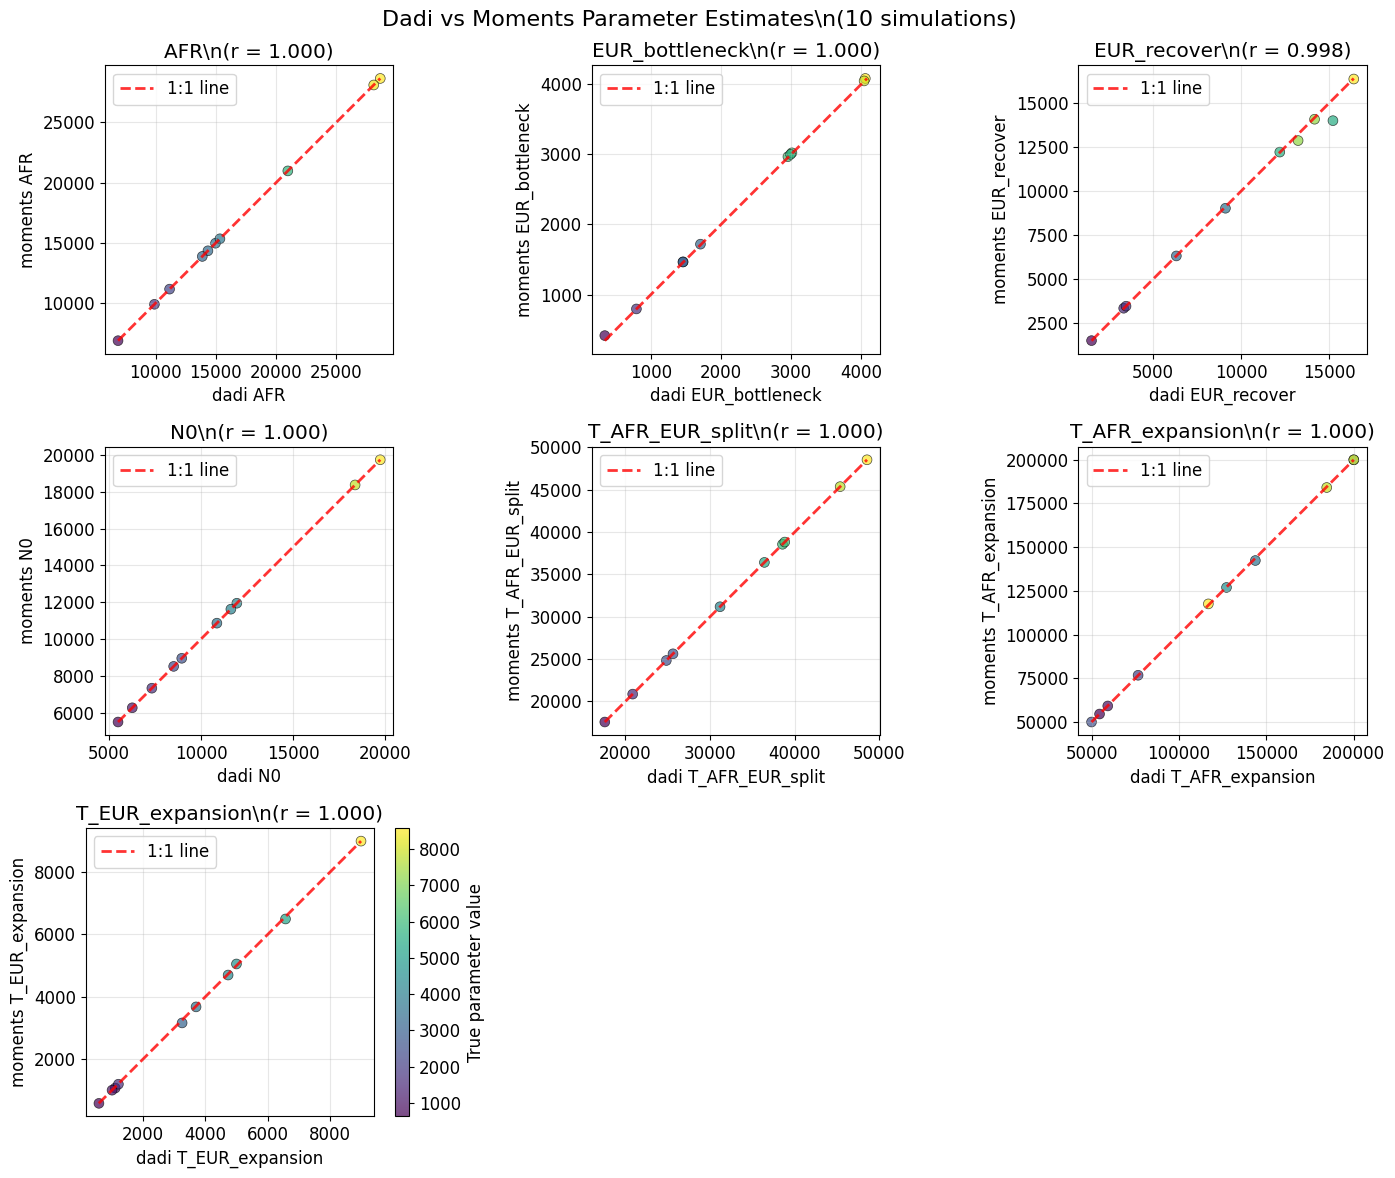

In [33]:
def plot_dadi_vs_moments_comparison(dadi_results, moments_results, ground_truth_params=None, output_dir=None):
    """Create scatter plots comparing dadi vs moments parameter estimates."""
    
    # Find common simulations and parameters
    common_sims = set(dadi_results.keys()) & set(moments_results.keys())
    if not common_sims:
        print("No common simulations found between dadi and moments results!")
        return None
    
    # Get parameter names from first simulation
    first_sim = list(common_sims)[0]
    dadi_params = set(dadi_results[first_sim]['best_params'].keys())
    moments_params = set(moments_results[first_sim]['best_params'].keys())
    common_params = sorted(dadi_params & moments_params)
    
    if not common_params:
        print("No common parameters found between dadi and moments results!")
        return None
    
    print(f"Creating dadi vs moments comparison for {len(common_params)} parameters across {len(common_sims)} simulations")
    print(f"Parameters: {common_params}")
    
    # Collect data for plotting
    comparison_data = {param: {'dadi': [], 'moments': [], 'true': []} for param in common_params}
    
    for sim_id in sorted(common_sims):
        for param in common_params:
            dadi_val = dadi_results[sim_id]['best_params'][param]
            moments_val = moments_results[sim_id]['best_params'][param]
            
            comparison_data[param]['dadi'].append(dadi_val)
            comparison_data[param]['moments'].append(moments_val)
            
            # Add true value if available
            if ground_truth_params and sim_id in ground_truth_params:
                true_val = ground_truth_params[sim_id].get(param, np.nan)
                comparison_data[param]['true'].append(true_val)
            else:
                comparison_data[param]['true'].append(np.nan)
    
    # Create plots
    n_params = len(common_params)
    n_cols = min(3, n_params)
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    if n_params == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, param in enumerate(common_params):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        dadi_vals = np.array(comparison_data[param]['dadi'])
        moments_vals = np.array(comparison_data[param]['moments'])
        true_vals = np.array(comparison_data[param]['true'])
        
        # Color by true values if available
        if not np.all(np.isnan(true_vals)):
            scatter = ax.scatter(dadi_vals, moments_vals, c=true_vals, cmap='viridis', 
                               s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
            # Add colorbar for the last subplot
            if i == len(common_params) - 1:
                plt.colorbar(scatter, ax=ax, label='True parameter value')
        else:
            ax.scatter(dadi_vals, moments_vals, s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
        
        # Add 1:1 reference line
        min_val = min(np.min(dadi_vals), np.min(moments_vals))
        max_val = max(np.max(dadi_vals), np.max(moments_vals))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8, label='1:1 line')
        
        # Calculate correlation
        corr_coef = np.corrcoef(dadi_vals, moments_vals)[0, 1]
        
        ax.set_xlabel(f'dadi {param}')
        ax.set_ylabel(f'moments {param}')
        ax.set_title(f'{param}\\n(r = {corr_coef:.3f})')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Make axes equal for better comparison
        ax.set_aspect('equal', adjustable='box')
    
    # Hide unused subplots
    for i in range(n_params, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows > 1:
            axes[row, col].set_visible(False)
        else:
            axes[col].set_visible(False)
    
    plt.suptitle(f'Dadi vs Moments Parameter Estimates\\n({len(common_sims)} simulations)', 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    
    # Save plot if output directory specified
    if output_dir:
        output_path = Path(output_dir) / 'dadi_vs_moments_comparison.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved comparison plot: {output_path}")
    
    plt.show()
    
    return fig, comparison_data

# Create the comparison plot
if common_sims:
    print("Creating dadi vs moments comparison plots...")
    fig, comparison_data = plot_dadi_vs_moments_comparison(
        dadi_results, 
        moments_results_inference, 
        ground_truth_params=ground_truth_params,
        output_dir=output_dir if 'output_dir' in locals() else None
    )
else:
    print("Cannot create comparison plots - no common simulations found.")

In [34]:
def analyze_dadi_moments_differences(dadi_results, moments_results, ground_truth_params=None):
    """Analyze statistical differences between dadi and moments estimates."""
    
    common_sims = set(dadi_results.keys()) & set(moments_results.keys())
    if not common_sims:
        print("No common simulations found!")
        return None
    
    # Get common parameters
    first_sim = list(common_sims)[0]
    dadi_params = set(dadi_results[first_sim]['best_params'].keys())
    moments_params = set(moments_results[first_sim]['best_params'].keys())
    common_params = sorted(dadi_params & moments_params)
    
    print(f"\\n📊 Statistical Analysis: Dadi vs Moments ({len(common_sims)} simulations)")
    print("=" * 70)
    
    analysis_results = {}
    
    for param in common_params:
        dadi_vals = []
        moments_vals = []
        true_vals = []
        
        for sim_id in sorted(common_sims):
            dadi_val = dadi_results[sim_id]['best_params'][param]
            moments_val = moments_results[sim_id]['best_params'][param]
            
            dadi_vals.append(dadi_val)
            moments_vals.append(moments_val)
            
            if ground_truth_params and sim_id in ground_truth_params:
                true_val = ground_truth_params[sim_id].get(param, np.nan)
                true_vals.append(true_val)
            else:
                true_vals.append(np.nan)
        
        dadi_vals = np.array(dadi_vals)
        moments_vals = np.array(moments_vals)
        true_vals = np.array(true_vals)
        
        # Calculate differences
        abs_diff = np.abs(dadi_vals - moments_vals)
        rel_diff = abs_diff / np.maximum(np.abs(dadi_vals), np.abs(moments_vals))
        
        # Statistical measures
        corr_coef = np.corrcoef(dadi_vals, moments_vals)[0, 1]
        mean_abs_diff = np.mean(abs_diff)
        median_abs_diff = np.median(abs_diff)
        mean_rel_diff = np.mean(rel_diff) * 100  # Convert to percentage
        median_rel_diff = np.median(rel_diff) * 100
        
        # Paired t-test
        from scipy.stats import ttest_rel
        t_stat, p_value = ttest_rel(dadi_vals, moments_vals)
        
        # Agreement analysis
        within_1pct = np.sum(rel_diff <= 0.01)
        within_5pct = np.sum(rel_diff <= 0.05)
        within_10pct = np.sum(rel_diff <= 0.10)
        
        analysis_results[param] = {
            'correlation': corr_coef,
            'mean_abs_diff': mean_abs_diff,
            'median_abs_diff': median_abs_diff,
            'mean_rel_diff': mean_rel_diff,
            'median_rel_diff': median_rel_diff,
            't_stat': t_stat,
            'p_value': p_value,
            'within_1pct': within_1pct,
            'within_5pct': within_5pct,
            'within_10pct': within_10pct,
            'n_comparisons': len(dadi_vals)
        }
        
        # Print results for this parameter
        print(f"\\n{param}:")
        print(f"  Correlation coefficient: {corr_coef:.4f}")
        print(f"  Mean absolute difference: {mean_abs_diff:.2e}")
        print(f"  Median absolute difference: {median_abs_diff:.2e}")
        print(f"  Mean relative difference: {mean_rel_diff:.2f}%")
        print(f"  Median relative difference: {median_rel_diff:.2f}%")
        print(f"  Paired t-test p-value: {p_value:.2e} {'(significant)' if p_value < 0.05 else '(not significant)'}")
        print(f"  Agreement within 1%: {within_1pct}/{len(dadi_vals)} ({100*within_1pct/len(dadi_vals):.1f}%)")
        print(f"  Agreement within 5%: {within_5pct}/{len(dadi_vals)} ({100*within_5pct/len(dadi_vals):.1f}%)")
        print(f"  Agreement within 10%: {within_10pct}/{len(dadi_vals)} ({100*within_10pct/len(dadi_vals):.1f}%)")
        
        # Compare accuracy to ground truth if available
        if not np.all(np.isnan(true_vals)):
            dadi_errors = np.abs(dadi_vals - true_vals) / np.abs(true_vals)
            moments_errors = np.abs(moments_vals - true_vals) / np.abs(true_vals)
            
            dadi_mean_error = np.nanmean(dadi_errors) * 100
            moments_mean_error = np.nanmean(moments_errors) * 100
            
            print(f"  Accuracy vs ground truth:")
            print(f"    Dadi mean relative error: {dadi_mean_error:.2f}%")
            print(f"    Moments mean relative error: {moments_mean_error:.2f}%")
            print(f"    Better method: {'Dadi' if dadi_mean_error < moments_mean_error else 'Moments'}")
    
    return analysis_results

# Perform statistical analysis
if common_sims and len(common_sims) > 1:
    analysis_results = analyze_dadi_moments_differences(
        dadi_results, 
        moments_results_inference, 
        ground_truth_params=ground_truth_params
    )
else:
    print("Need at least 2 common simulations for statistical analysis.")

\n📊 Statistical Analysis: Dadi vs Moments (10 simulations)
\nAFR:
  Correlation coefficient: 1.0000
  Mean absolute difference: 6.18e-12
  Median absolute difference: 3.64e-12
  Mean relative difference: 0.00%
  Median relative difference: 0.00%
  Paired t-test p-value: 8.11e-01 (not significant)
  Agreement within 1%: 10/10 (100.0%)
  Agreement within 5%: 10/10 (100.0%)
  Agreement within 10%: 10/10 (100.0%)
  Accuracy vs ground truth:
    Dadi mean relative error: 0.00%
    Moments mean relative error: 0.00%
    Better method: Moments
\nEUR_bottleneck:
  Correlation coefficient: 0.9999
  Mean absolute difference: 1.63e+01
  Median absolute difference: 9.38e+00
  Mean relative difference: 2.12%
  Median relative difference: 0.45%
  Paired t-test p-value: 3.45e-02 (significant)
  Agreement within 1%: 9/10 (90.0%)
  Agreement within 5%: 9/10 (90.0%)
  Agreement within 10%: 9/10 (90.0%)
  Accuracy vs ground truth:
    Dadi mean relative error: 4.98%
    Moments mean relative error: 6.60%

\nCreating Bland-Altman plots for method agreement...
Creating Bland-Altman plots for method agreement analysis...
Saved Bland-Altman plot: /sietch_colab/akapoor/Infer_Demography/notebooks/analysis_results/bland_altman_dadi_moments.png


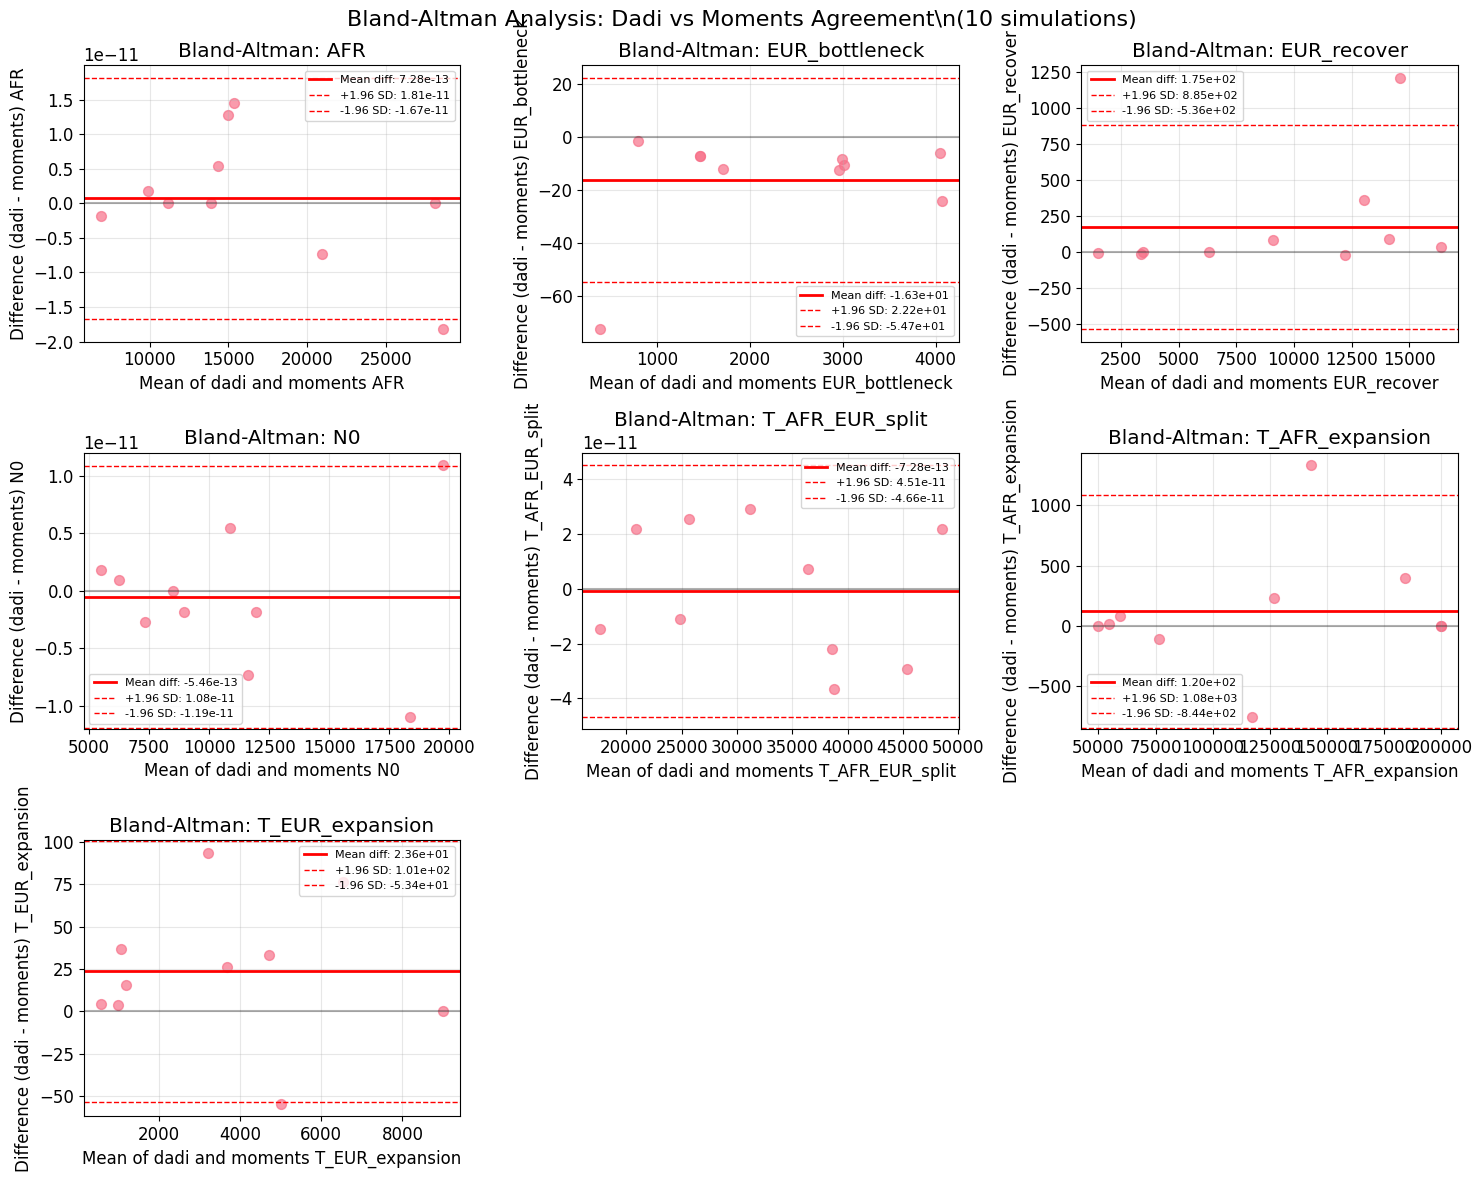

In [35]:
def plot_bland_altman_analysis(dadi_results, moments_results, output_dir=None):
    """Create Bland-Altman plots to assess agreement between dadi and moments."""
    
    common_sims = set(dadi_results.keys()) & set(moments_results.keys())
    if not common_sims:
        print("No common simulations found!")
        return None
    
    # Get common parameters
    first_sim = list(common_sims)[0]
    dadi_params = set(dadi_results[first_sim]['best_params'].keys())
    moments_params = set(moments_results[first_sim]['best_params'].keys())
    common_params = sorted(dadi_params & moments_params)
    
    print(f"Creating Bland-Altman plots for method agreement analysis...")
    
    n_params = len(common_params)
    n_cols = min(3, n_params)
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    if n_params == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, param in enumerate(common_params):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        dadi_vals = []
        moments_vals = []
        
        for sim_id in sorted(common_sims):
            dadi_vals.append(dadi_results[sim_id]['best_params'][param])
            moments_vals.append(moments_results[sim_id]['best_params'][param])
        
        dadi_vals = np.array(dadi_vals)
        moments_vals = np.array(moments_vals)
        
        # Bland-Altman plot: difference vs mean
        mean_vals = (dadi_vals + moments_vals) / 2
        diff_vals = dadi_vals - moments_vals
        
        # Calculate statistics
        mean_diff = np.mean(diff_vals)
        std_diff = np.std(diff_vals)
        
        # Plot
        ax.scatter(mean_vals, diff_vals, alpha=0.7, s=50)
        
        # Add reference lines
        ax.axhline(mean_diff, color='red', linestyle='-', linewidth=2, 
                  label=f'Mean diff: {mean_diff:.2e}')
        ax.axhline(mean_diff + 1.96*std_diff, color='red', linestyle='--', linewidth=1,
                  label=f'+1.96 SD: {mean_diff + 1.96*std_diff:.2e}')
        ax.axhline(mean_diff - 1.96*std_diff, color='red', linestyle='--', linewidth=1,
                  label=f'-1.96 SD: {mean_diff - 1.96*std_diff:.2e}')
        ax.axhline(0, color='black', linestyle='-', alpha=0.3)
        
        ax.set_xlabel(f'Mean of dadi and moments {param}')
        ax.set_ylabel(f'Difference (dadi - moments) {param}')
        ax.set_title(f'Bland-Altman: {param}')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    # Hide unused subplots
    for i in range(n_params, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows > 1:
            axes[row, col].set_visible(False)
        else:
            axes[col].set_visible(False)
    
    plt.suptitle(f'Bland-Altman Analysis: Dadi vs Moments Agreement\\n({len(common_sims)} simulations)', 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    
    # Save plot if output directory specified
    if output_dir:
        output_path = Path(output_dir) / 'bland_altman_dadi_moments.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved Bland-Altman plot: {output_path}")
    
    plt.show()
    return fig

# Create Bland-Altman plots
if common_sims and len(common_sims) > 1:
    print("\\nCreating Bland-Altman plots for method agreement...")
    bland_altman_fig = plot_bland_altman_analysis(
        dadi_results, 
        moments_results_inference,
        output_dir=output_dir if 'output_dir' in locals() else None
    )
else:
    print("Need at least 2 common simulations for Bland-Altman analysis.")

In [36]:
def create_method_comparison_summary(analysis_results, output_dir=None):
    """Create a summary table comparing dadi and moments performance."""
    
    if not analysis_results:
        print("No analysis results available for summary.")
        return None
    
    # Create summary DataFrame
    summary_data = []
    for param, results in analysis_results.items():
        summary_data.append({
            'Parameter': param,
            'Correlation': f"{results['correlation']:.4f}",
            'Mean_Rel_Diff_%': f"{results['mean_rel_diff']:.2f}",
            'Median_Rel_Diff_%': f"{results['median_rel_diff']:.2f}",
            'Agreement_1%': f"{results['within_1pct']}/{results['n_comparisons']} ({100*results['within_1pct']/results['n_comparisons']:.1f}%)",
            'Agreement_5%': f"{results['within_5pct']}/{results['n_comparisons']} ({100*results['within_5pct']/results['n_comparisons']:.1f}%)",
            'Agreement_10%': f"{results['within_10pct']}/{results['n_comparisons']} ({100*results['within_10pct']/results['n_comparisons']:.1f}%)",
            'P_Value': f"{results['p_value']:.2e}",
            'Significant': 'Yes' if results['p_value'] < 0.05 else 'No'
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    print("\\n📋 Dadi vs Moments Comparison Summary")
    print("=" * 100)
    print(summary_df.to_string(index=False))
    
    # Save summary table
    if output_dir:
        output_path = Path(output_dir) / 'dadi_moments_comparison_summary.csv'
        summary_df.to_csv(output_path, index=False)
        print(f"\\nSaved comparison summary: {output_path}")
    
    return summary_df

# Create summary table
if 'analysis_results' in locals() and analysis_results:
    summary_df = create_method_comparison_summary(
        analysis_results,
        output_dir=output_dir if 'output_dir' in locals() else None
    )
    
    # Display key insights
    print("\\n🔍 Key Insights:")
    if summary_df is not None:
        # Find parameters with high correlation
        high_corr_params = []
        low_corr_params = []
        
        for param, results in analysis_results.items():
            if results['correlation'] > 0.95:
                high_corr_params.append(param)
            elif results['correlation'] < 0.90:
                low_corr_params.append(param)
        
        if high_corr_params:
            print(f"  • High correlation (>0.95): {', '.join(high_corr_params)}")
        if low_corr_params:
            print(f"  • Lower correlation (<0.90): {', '.join(low_corr_params)}")
        
        # Find parameters with good agreement
        good_agreement_params = []
        for param, results in analysis_results.items():
            if results['within_5pct'] / results['n_comparisons'] > 0.8:
                good_agreement_params.append(param)
        
        if good_agreement_params:
            print(f"  • Good agreement (>80% within 5%): {', '.join(good_agreement_params)}")
        
        # Overall assessment
        mean_correlation = np.mean([results['correlation'] for results in analysis_results.values()])
        print(f"  • Overall mean correlation: {mean_correlation:.4f}")
        
        significant_differences = sum(1 for results in analysis_results.values() if results['p_value'] < 0.05)
        print(f"  • Parameters with significant differences: {significant_differences}/{len(analysis_results)}")
else:
    print("No analysis results available for summary insights.")

\n📋 Dadi vs Moments Comparison Summary
      Parameter Correlation Mean_Rel_Diff_% Median_Rel_Diff_%   Agreement_1%   Agreement_5%  Agreement_10%  P_Value Significant
            AFR      1.0000            0.00              0.00 10/10 (100.0%) 10/10 (100.0%) 10/10 (100.0%) 8.11e-01          No
 EUR_bottleneck      0.9999            2.12              0.45   9/10 (90.0%)   9/10 (90.0%)   9/10 (90.0%) 3.45e-02         Yes
    EUR_recover      0.9980            1.34              0.36   8/10 (80.0%)   9/10 (90.0%) 10/10 (100.0%) 1.82e-01          No
             N0      1.0000            0.00              0.00 10/10 (100.0%) 10/10 (100.0%) 10/10 (100.0%) 7.84e-01          No
T_AFR_EUR_split      1.0000            0.00              0.00 10/10 (100.0%) 10/10 (100.0%) 10/10 (100.0%) 9.28e-01          No
T_AFR_expansion      1.0000            0.23              0.14 10/10 (100.0%) 10/10 (100.0%) 10/10 (100.0%) 4.82e-01          No
T_EUR_expansion      0.9999            1.23              0.92   5